In [1]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
# then restart kernel 

#### Current state of project: 
I might not touch this notebook for a while (outside of maybe some data viz and data analysis) until I build my own sql database for chess games. I would like to use that database to get more information on the players (opening and color statistics etc.) I'm also working on a chess player style identifier, which I might use as well as a feature here. 

Othen than that, more complicated additions I'm considering:
- looking for similarities between players based on mainly openings
- adding features based on other games from the database e.g. favourite opening, score with white and black, avg game length etc. 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import re
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight') # data viz style
pd.set_option('display.max_columns', None)

def load_games():
    seasons = ['15-16.csv','16-17.csv','17-18.csv','18-19.csv','19-20.csv']   #in case of google colab use files.upload()
    dfs = []

    for filename in seasons:

        dfs.append(pd.read_csv(filename, encoding='utf8', names=['Home team', 'Away team', 'Board no. ', 'Title home', 'Elo home',
                                                          'Player home','Color home', 'Result', 'Color away',
                                                          'Player away','Elo away','Title away', 'Date', 'Time', 'League', 'Round', 'Season']) )

    #Concatenate all data into one DataFrame
    all_games = pd.concat(dfs, ignore_index=True)
    
    return all_games


df = load_games()
df.head()

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Result,Color away,Player away,Elo away,Title away,Date,Time,League,Round,Season
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,black,01,white,Jankovic Alojzije,2557,GM,2015-11-07,15:00,nb1,0,15-16
1,HÜSI SC,HVSE-Infraplan,2,NaN,2362,Havasi Gergő,white,½½,black,Ruck Róbert,2565,GM,2015-11-07,15:00,nb1,0,15-16
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,black,½½,white,Németh Miklós,2469,IM,2015-11-07,15:00,nb1,0,15-16
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,white,½½,black,Dr. Kovács Gábor,2462,IM,2015-11-07,15:00,nb1,0,15-16
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,black,½½,white,Mészáros Michal,2389,IM,2015-11-07,15:00,nb1,0,15-16


In [3]:
def correct_round(df):
  
  df['Round'] = df['Round'].apply(np.int64 ) #change object type to numerical 
  
  return df

df = correct_round(df)
df

def drop_no_team_row(df):
  
    # after the webscraping some games were missing due to being postponed because of covid, I'll remove these now
    df.drop(df[(df['Home team'] == 'Cs1') | (df['Home team'] == 'Cs2')].index, inplace=True)
    df.reset_index()

    return df


def convert_result(df):
    
    # the format of the results was not numerical, let's change that 
    # in order to easily create visualizations I'll create a result feature for both the home and away player
    # for modeling these will not be needed, and should be removed as they correlation is high(1 to be exact)
    # TODO: replace might be better here
    
    df.loc[:,'Result_home'] = df['Result'].apply(lambda x: 0 if x == '01' else (0.5 if x == '½½' else 1))
    df.loc[:,'Result_away'] = df['Result'].apply(lambda x: 1 if x == '01' else (0.5 if x == '½½' else 0))

    del df['Result'] # i don't need this anymore
    
    df.reindex(df.columns, axis=1)
    
    return df

df = drop_no_team_row(df)
df = convert_result(df)
df.head()

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,Title away,Date,Time,League,Round,Season,Result_home,Result_away
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,black,white,Jankovic Alojzije,2557,GM,2015-11-07,15:00,nb1,0,15-16,0.0,1.0
1,HÜSI SC,HVSE-Infraplan,2,NaN,2362,Havasi Gergő,white,black,Ruck Róbert,2565,GM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,black,white,Németh Miklós,2469,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,white,black,Dr. Kovács Gábor,2462,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,black,white,Mészáros Michal,2389,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5


In [4]:
%%time

'''Some columns need corrections'''
def correct_columns(df):
    
    # some elo values had parentheses to indicate the national elo (and not international), so i remove those, because
    # usually that elo still indicates the strength of the player well

    df.loc[:,'Elo home'] = df.loc[:,'Elo home'].str.extract('(\d+)', expand=False).fillna(1400)
    df.loc[:,'Elo away'] = df.loc[:,'Elo away'].str.extract('(\d+)', expand=False).fillna(1400)

    df.loc[:,'Title home'] = df.loc[:,'Title home'].apply(lambda x: 'No Title' if pd.isnull(x) else x)
    df.loc[:,'Title away'] = df.loc[:,'Title away'].apply(lambda x: 'No Title' if pd.isnull(x) else x ) 

    # make color numerical instead of categorical (white = 0, black = 1)
    df.loc[:,'Color home'] = df.loc[:,'Color home'].apply(lambda x: 0 if x == 'white' else 1)
    df.loc[:,'Color away'] = df.loc[:,'Color away'].apply(lambda x: 0 if x == 'white' else 1)

    # to make the starting time more exact, I changed 10 to 10:00 as it indicates time much more imo 
    df.loc[:,'Time'] = df.loc[:,'Time'].str[0:2]+':00'
    
    # diff btw the home and away player - positive value means home player has higher elo
    df.loc[:,'Elo diff'] = df.loc[:,'Elo home'].astype(float) - df.loc[:,'Elo away'].astype(float)

    return df 

df = correct_columns(df)
df.head()

Wall time: 831 ms


,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,Title away,Date,Time,League,Round,Season,Result_home,Result_away,Elo diff
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,GM,2015-11-07,15:00,nb1,0,15-16,0.0,1.0,-183.0
1,HÜSI SC,HVSE-Infraplan,2,No Title,2362,Havasi Gergő,0,1,Ruck Róbert,2565,GM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5,-203.0
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,1,0,Németh Miklós,2469,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5,1.0
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,0,1,Dr. Kovács Gábor,2462,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5,-38.0
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,1,0,Mészáros Michal,2389,IM,2015-11-07,15:00,nb1,0,15-16,0.5,0.5,37.0


In [5]:
import csv
import os

'''Loads the rankinglists of the leagues'''
def load_rankinglists():
  
    ranklists = [] 
    dfs = []
    
    # the ranklists on my comp all start with 1 (it represents the saeson like 16-17) and contain "nb" (e g nb1) 
    
    keyword = 'nb'   #in case of google colab just use files.upload()
    for filename in os.listdir('.'):
        if keyword in filename and filename.startswith("1") and filename.endswith(".csv"):
            ranklists.append(filename)
            
    for filename in ranklists:
        with open(filename, encoding="utf-8") as f:
            reader = csv.reader(f, delimiter=',', skipinitialspace=True)
            next(reader)
            num_col = 0 
            while(num_col == 0 ):
                num_col= len(next(reader))

        season = re.compile(r'(\d\d-\d\d)').match(filename).group(0) # i need to store the season from the filename itself
        league = re.compile(r'\d\d-\d\d(.+)').match(filename).group(1) # need to store the league name from the filename as well 
        league = league[:-4] # the first 4 letters represents it just as well 
        
        # i could've made this one nicer but it was fast enough 
        full_columns = ['Index','Player name', 'Youth','Female', 'Nationality', 'Title', 'Elo',
                                                              'Round 1','Round 2', 'Round 3', 'Round 4','Round 5','Round 6','Round 7', 'Round 8', 'Round 9', 'Round 10', 'Round 11', 'Total',
                                                              'Born year', 'Team name', 'Standard elo', 'Rapid elo', 'Blitz elo',
                                                              'Game no 2021-Feb standard','Game no 2021-Feb rapid', 'Game no 2021-Feb blitz',
                                                             'Game no 2021-Jan standard','Game no 2021-Jan rapid', 'Game no 2021-Jan blitz',
                                                             'Game no 2020-Dec standard','Game no 2020-Dec rapid', 'Game no 2020-Dec blitz',
                                                             'Game no 2020-Nov standard','Game no 2020-Nov rapid', 'Game no 2020-Nov blitz',
                                                             'Game no 2020-Oct standard','Game no 2020-Oct rapid', 'Game no 2020-Oct blitz',
                                                             'Game no 2020-Sep standard','Game no 2020-Sep rapid', 'Game no 2020-Sep blitz',
                                                             'Game no 2020-Aug standard','Game no 2020-Aug rapid', 'Game no 2020-Aug blitz',
                                                             'Game no 2020-Jul standard','Game no 2020-Jul rapid', 'Game no 2020-Jul blitz',
                                                             'Game no 2020-Jun standard','Game no 2020-Jun rapid', 'Game no 2020-Jun blitz',
                                                             'Game no 2020-May standard','Game no 2020-May rapid', 'Game no 2020-May blitz',
                                                             'Game no 2020-Apr standard','Game no 2020-Apr rapid', 'Game no 2020-Apr blitz',
                                                             'Game no 2020-Mar standard','Game no 2020-Mar rapid', 'Game no 2020-Mar blitz',
                                                             'Game no 2020-Feb standard','Game no 2020-Feb rapid', 'Game no 2020-Feb blitz',
                                                             'Game no 2020-Jan standard','Game no 2020-Jan rapid', 'Game no 2020-Jan blitz',
                                                             'Game no 2019-Dec standard','Game no 2019-Dec rapid', 'Game no 2019-Dec blitz',
                                                             'Game no 2019-Nov standard','Game no 2019-Nov rapid', 'Game no 2019-Nov blitz',
                                                             'Game no 2019-Oct standard','Game no 2019-Oct rapid', 'Game no 2019-Oct blitz',
                                                             'Game no 2019-Sep standard','Game no 2019-Sep rapid', 'Game no 2019-Sep blitz',
                                                             'Game no 2019-Aug standard','Game no 2019-Aug rapid', 'Game no 2019-Aug blitz',
                                                             'Game no 2019-Jul standard','Game no 2019-Jul rapid', 'Game no 2019-Jul blitz',
                                                             'Game no 2019-Jun standard','Game no 2019-Jun rapid', 'Game no 2019-Jun blitz',
                                                             'Game no 2019-May standard','Game no 2019-May rapid', 'Game no 2019-May blitz',
                                                             'Game no 2019-Apr standard','Game no 2019-Apr rapid', 'Game no 2019-Apr blitz',
                                                             'Game no 2019-Mar standard','Game no 2019-Mar rapid', 'Game no 2019-Mar blitz',
                                                             'Game no 2019-Feb standard','Game no 2019-Feb rapid', 'Game no 2019-Feb blitz',
                                                             'Game no 2019-Jan standard','Game no 2019-Jan rapid', 'Game no 2019-Jan blitz',                                                         
                                                             'Game no 2018-Dec standard','Game no 2018-Dec rapid', 'Game no 2018-Dec blitz',
                                                             'Game no 2018-Nov standard','Game no 2018-Nov rapid', 'Game no 2018-Nov blitz',
                                                             'Game no 2018-Oct standard','Game no 2018-Oct rapid', 'Game no 2018-Oct blitz',
                                                             'Game no 2018-Sep standard','Game no 2018-Sep rapid', 'Game no 2018-Sep blitz',
                                                             'Game no 2018-Aug standard','Game no 2018-Aug rapid', 'Game no 2018-Aug blitz',
                                                             'Game no 2018-Jul standard','Game no 2018-Jul rapid', 'Game no 2018-Jul blitz',
                                                             'Game no 2018-Jun standard','Game no 2018-Jun rapid', 'Game no 2018-Jun blitz',
                                                             'Game no 2018-May standard','Game no 2018-May rapid', 'Game no 2018-May blitz',
                                                             'Game no 2018-Apr standard','Game no 2018-Apr rapid', 'Game no 2018-Apr blitz',
                                                             'Game no 2018-Mar standard','Game no 2018-Mar rapid', 'Game no 2018-Mar blitz',
                                                             'Game no 2018-Feb standard','Game no 2018-Feb rapid', 'Game no 2018-Feb blitz',
                                                             'Game no 2018-Jan standard','Game no 2018-Jan rapid', 'Game no 2018-Jan blitz',                                                         
                                                             'Game no 2017-Dec standard','Game no 2017-Dec rapid', 'Game no 2017-Dec blitz',
                                                             'Game no 2017-Nov standard','Game no 2017-Nov rapid', 'Game no 2017-Nov blitz',
                                                             'Game no 2017-Oct standard','Game no 2017-Oct rapid', 'Game no 2017-Oct blitz',
                                                             'Game no 2017-Sep standard','Game no 2017-Sep rapid', 'Game no 2017-Sep blitz',
                                                             'Game no 2017-Aug standard','Game no 2017-Aug rapid', 'Game no 2017-Aug blitz',
                                                             'Game no 2017-Jul standard','Game no 2017-Jul rapid', 'Game no 2017-Jul blitz',
                                                             'Game no 2017-Jun standard','Game no 2017-Jun rapid', 'Game no 2017-Jun blitz',
                                                             'Game no 2017-May standard','Game no 2017-May rapid', 'Game no 2017-May blitz',
                                                             'Game no 2017-Apr standard','Game no 2017-Apr rapid', 'Game no 2017-Apr blitz',
                                                             'Game no 2017-Mar standard','Game no 2017-Mar rapid', 'Game no 2017-Mar blitz',
                                                             'Game no 2017-Feb standard','Game no 2017-Feb rapid', 'Game no 2017-Feb blitz',
                                                             'Game no 2017-Jan standard','Game no 2017-Jan rapid', 'Game no 2017-Jan blitz',                                                         
                                                             'Game no 2016-Dec standard','Game no 2016-Dec rapid', 'Game no 2016-Dec blitz',
                                                             'Game no 2016-Nov standard','Game no 2016-Nov rapid', 'Game no 2016-Nov blitz',
                                                             'Game no 2016-Oct standard','Game no 2016-Oct rapid', 'Game no 2016-Oct blitz',
                                                             'Game no 2016-Sep standard','Game no 2016-Sep rapid', 'Game no 2016-Sep blitz',
                                                             'Game no 2016-Aug standard','Game no 2016-Aug rapid', 'Game no 2016-Aug blitz',
                                                             'Game no 2016-Jul standard','Game no 2016-Jul rapid', 'Game no 2016-Jul blitz',
                                                             'Game no 2016-Jun standard','Game no 2016-Jun rapid', 'Game no 2016-Jun blitz',
                                                             'Game no 2016-May standard','Game no 2016-May rapid', 'Game no 2016-May blitz',
                                                             'Game no 2016-Apr standard','Game no 2016-Apr rapid', 'Game no 2016-Apr blitz',
                                                             'Game no 2016-Mar standard','Game no 2016-Mar rapid', 'Game no 2016-Mar blitz',
                                                             'Game no 2016-Feb standard','Game no 2016-Feb rapid', 'Game no 2016-Feb blitz',
                                                             'Game no 2016-Jan standard','Game no 2016-Jan rapid', 'Game no 2016-Jan blitz',                                                         
                                                             'Game no 2015-Dec standard','Game no 2015-Dec rapid', 'Game no 2015-Dec blitz',
                                                             'Game no 2015-Nov standard','Game no 2015-Nov rapid', 'Game no 2015-Nov blitz',
                                                             'Game no 2015-Oct standard','Game no 2015-Oct rapid', 'Game no 2015-Oct blitz',
                                                             'Game no 2015-Sep standard','Game no 2015-Sep rapid', 'Game no 2015-Sep blitz',
                                                             'Game no 2015-Aug standard','Game no 2015-Aug rapid', 'Game no 2015-Aug blitz',
                                                             'Game no 2015-Jul standard','Game no 2015-Jul rapid', 'Game no 2015-Jul blitz',
                                                             'Game no 2015-Jun standard','Game no 2015-Jun rapid', 'Game no 2015-Jun blitz',
                                                             'Game no 2015-May standard','Game no 2015-May rapid', 'Game no 2015-May blitz',
                                                             'Game no 2015-Apr standard','Game no 2015-Apr rapid', 'Game no 2015-Apr blitz',
                                                             'Game no 2015-Mar standard','Game no 2015-Mar rapid', 'Game no 2015-Mar blitz',
                                                             'Game no 2015-Feb standard','Game no 2015-Feb rapid', 'Game no 2015-Feb blitz',                                                         
                                                             'Rating change 2021-Feb standard','Rating change 2021-Feb rapid', 'Rating change 2021-Feb blitz',
                                                             'Rating change 2021-Jan standard','Rating change 2021-Jan rapid', 'Rating change 2021-Jan blitz',
                                                             'Rating change 2020-Dec standard','Rating change 2020-Dec rapid', 'Rating change 2020-Dec blitz',
                                                             'Rating change 2020-Nov standard','Rating change 2020-Nov rapid', 'Rating change 2020-Nov blitz',
                                                             'Rating change 2020-Oct standard','Rating change 2020-Oct rapid', 'Rating change 2020-Oct blitz',
                                                             'Rating change 2020-Sep standard','Rating change 2020-Sep rapid', 'Rating change 2020-Sep blitz',
                                                             'Rating change 2020-Aug standard','Rating change 2020-Aug rapid', 'Rating change 2020-Aug blitz',
                                                             'Rating change 2020-Jul standard','Rating change 2020-Jul rapid', 'Rating change 2020-Jul blitz',
                                                             'Rating change 2020-Jun standard','Rating change 2020-Jun rapid', 'Rating change 2020-Jun blitz',
                                                             'Rating change 2020-May standard','Rating change 2020-May rapid', 'Rating change 2020-May blitz',
                                                             'Rating change 2020-Apr standard','Rating change 2020-Apr rapid', 'Rating change 2020-Apr blitz',
                                                             'Rating change 2020-Mar standard','Rating change 2020-Mar rapid', 'Rating change 2020-Mar blitz',
                                                             'Rating change 2020-Feb standard','Rating change 2020-Feb rapid', 'Rating change 2020-Feb blitz',
                                                             'Rating change 2020-Jan standard','Rating change 2020-Jan rapid', 'Rating change 2020-Jan blitz',
                                                             'Rating change 2019-Dec standard','Rating change 2019-Dec rapid', 'Rating change 2019-Dec blitz',
                                                             'Rating change 2019-Nov standard','Rating change 2019-Nov rapid', 'Rating change 2019-Nov blitz',
                                                             'Rating change 2019-Oct standard','Rating change 2019-Oct rapid', 'Rating change 2019-Oct blitz',
                                                             'Rating change 2019-Sep standard','Rating change 2019-Sep rapid', 'Rating change 2019-Sep blitz',
                                                             'Rating change 2019-Aug standard','Rating change 2019-Aug rapid', 'Rating change 2019-Aug blitz',
                                                             'Rating change 2019-Jul standard','Rating change 2019-Jul rapid', 'Rating change 2019-Jul blitz',
                                                             'Rating change 2019-Jun standard','Rating change 2019-Jun rapid', 'Rating change 2019-Jun blitz',
                                                             'Rating change 2019-May standard','Rating change 2019-May rapid', 'Rating change 2019-May blitz',
                                                             'Rating change 2019-Apr standard','Rating change 2019-Apr rapid', 'Rating change 2019-Apr blitz',
                                                             'Rating change 2019-Mar standard','Rating change 2019-Mar rapid', 'Rating change 2019-Mar blitz',
                                                             'Rating change 2019-Feb standard','Rating change 2019-Feb rapid', 'Rating change 2019-Feb blitz',
                                                             'Rating change 2019-Jan standard','Rating change 2019-Jan rapid', 'Rating change 2019-Jan blitz',
                                                             'Rating change 2018-Dec standard','Rating change 2018-Dec rapid', 'Rating change 2018-Dec blitz',
                                                             'Rating change 2018-Nov standard','Rating change 2018-Nov rapid', 'Rating change 2018-Nov blitz',
                                                             'Rating change 2018-Oct standard','Rating change 2018-Oct rapid', 'Rating change 2018-Oct blitz',
                                                             'Rating change 2018-Sep standard','Rating change 2018-Sep rapid', 'Rating change 2018-Sep blitz',
                                                             'Rating change 2018-Aug standard','Rating change 2018-Aug rapid', 'Rating change 2018-Aug blitz',
                                                             'Rating change 2018-Jul standard','Rating change 2018-Jul rapid', 'Rating change 2018-Jul blitz',
                                                             'Rating change 2018-Jun standard','Rating change 2018-Jun rapid', 'Rating change 2018-Jun blitz',
                                                             'Rating change 2018-May standard','Rating change 2018-May rapid', 'Rating change 2018-May blitz',
                                                             'Rating change 2018-Apr standard','Rating change 2018-Apr rapid', 'Rating change 2018-Apr blitz',
                                                             'Rating change 2018-Mar standard','Rating change 2018-Mar rapid', 'Rating change 2018-Mar blitz',
                                                             'Rating change 2018-Feb standard','Rating change 2018-Feb rapid', 'Rating change 2018-Feb blitz',
                                                             'Rating change 2018-Jan standard','Rating change 2018-Jan rapid', 'Rating change 2018-Jan blitz',                                                         
                                                             'Rating change 2017-Dec standard','Rating change 2017-Dec rapid', 'Rating change 2017-Dec blitz',
                                                             'Rating change 2017-Nov standard','Rating change 2017-Nov rapid', 'Rating change 2017-Nov blitz',
                                                             'Rating change 2017-Oct standard','Rating change 2017-Oct rapid', 'Rating change 2017-Oct blitz',
                                                             'Rating change 2017-Sep standard','Rating change 2017-Sep rapid', 'Rating change 2017-Sep blitz',
                                                             'Rating change 2017-Aug standard','Rating change 2017-Aug rapid', 'Rating change 2017-Aug blitz',
                                                             'Rating change 2017-Jul standard','Rating change 2017-Jul rapid', 'Rating change 2017-Jul blitz',
                                                             'Rating change 2017-Jun standard','Rating change 2017-Jun rapid', 'Rating change 2017-Jun blitz',
                                                             'Rating change 2017-May standard','Rating change 2017-May rapid', 'Rating change 2017-May blitz',
                                                             'Rating change 2017-Apr standard','Rating change 2017-Apr rapid', 'Rating change 2017-Apr blitz',
                                                             'Rating change 2017-Mar standard','Rating change 2017-Mar rapid', 'Rating change 2017-Mar blitz',
                                                             'Rating change 2017-Feb standard','Rating change 2017-Feb rapid', 'Rating change 2017-Feb blitz',
                                                             'Rating change 2017-Jan standard','Rating change 2017-Jan rapid', 'Rating change 2017-Jan blitz',                                                         
                                                             'Rating change 2016-Dec standard','Rating change 2016-Dec rapid', 'Rating change 2016-Dec blitz',
                                                             'Rating change 2016-Nov standard','Rating change 2016-Nov rapid', 'Rating change 2016-Nov blitz',
                                                             'Rating change 2016-Oct standard','Rating change 2016-Oct rapid', 'Rating change 2016-Oct blitz',
                                                             'Rating change 2016-Sep standard','Rating change 2016-Sep rapid', 'Rating change 2016-Sep blitz',
                                                             'Rating change 2016-Aug standard','Rating change 2016-Aug rapid', 'Rating change 2016-Aug blitz',
                                                             'Rating change 2016-Jul standard','Rating change 2016-Jul rapid', 'Rating change 2016-Jul blitz',
                                                             'Rating change 2016-Jun standard','Rating change 2016-Jun rapid', 'Rating change 2016-Jun blitz',
                                                             'Rating change 2016-May standard','Rating change 2016-May rapid', 'Rating change 2016-May blitz',
                                                             'Rating change 2016-Apr standard','Rating change 2016-Apr rapid', 'Rating change 2016-Apr blitz',
                                                             'Rating change 2016-Mar standard','Rating change 2016-Mar rapid', 'Rating change 2016-Mar blitz',
                                                             'Rating change 2016-Feb standard','Rating change 2016-Feb rapid', 'Rating change 2016-Feb blitz',
                                                             'Rating change 2016-Jan standard','Rating change 2016-Jan rapid', 'Rating change 2016-Jan blitz',                                                         
                                                             'Rating change 2015-Dec standard','Rating change 2015-Dec rapid', 'Rating change 2015-Dec blitz',
                                                             'Rating change 2015-Nov standard','Rating change 2015-Nov rapid', 'Rating change 2015-Nov blitz',
                                                             'Rating change 2015-Oct standard','Rating change 2015-Oct rapid', 'Rating change 2015-Oct blitz',
                                                             'Rating change 2015-Sep standard','Rating change 2015-Sep rapid', 'Rating change 2015-Sep blitz',
                                                             'Rating change 2015-Aug standard','Rating change 2015-Aug rapid', 'Rating change 2015-Aug blitz',
                                                             'Rating change 2015-Jul standard','Rating change 2015-Jul rapid', 'Rating change 2015-Jul blitz',
                                                             'Rating change 2015-Jun standard','Rating change 2015-Jun rapid', 'Rating change 2015-Jun blitz',
                                                             'Rating change 2015-May standard','Rating change 2015-May rapid', 'Rating change 2015-May blitz',
                                                             'Rating change 2015-Apr standard','Rating change 2015-Apr rapid', 'Rating change 2015-Apr blitz',
                                                             'Rating change 2015-Mar standard','Rating change 2015-Mar rapid', 'Rating change 2015-Mar blitz',
                                                             'Rating change 2015-Feb standard','Rating change 2015-Feb rapid', 'Rating change 2015-Feb blitz',
                                                             'Rating change 2015-Jan standard','Rating change 2015-Jan rapid', 'Rating change 2015-Jan blitz']


        # some league played less games due to the league containing less teams
        # i correct the columns according to this now 
        
        if(num_col == 463):
            full_columns.remove('Round 10')
            full_columns.remove('Round 11')
            
        elif(num_col == 464):
            full_columns.remove('Round 11')
            
        ranklist = pd.read_csv(filename, encoding='utf8',index_col=0, names=full_columns)
        ranklist['Season'] = season
        ranklist['League'] = league
        
        # got to handle the missing columns
        
        if(num_col == 463):
            ranklist['Round 10'] = 'No game was played'
            ranklist['Round 11'] = 'No game was played'
            
        elif(num_col == 464):
            ranklist['Round 11'] = 'No game was played'
         
        dfs.append(ranklist) # storing the ranklists in an array 
 
    all_ranklist = pd.concat(dfs, ignore_index=True) # concatenate them together
    return all_ranklist

all_ranklist=load_rankinglists()
all_ranklist.head()


,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,Rating change 2015-Feb standard,Rating change 2015-Feb rapid,Rating change 2015-Feb blitz,Rating change 2015-Jan standard,Rating change 2015-Jan rapid,Rating change 2015-Jan blitz,Season,League,Round 10,Round 11
0,Anand Viswanathan,NaN,NaN,IND,GM,2816.0,NaN,NaN,NaN,NaN,...,No Games,No Games,No Games,Available 3.9,Available -1,Available -44,15-16,nb1,No game was played,No game was played
1,Naiditsch Arkadij,NaN,NaN,GER,GM,2684.0,NaN,NaN,NaN,NaN,...,Available 12.4,No Games,No Games,Available -37.1,No Games,No Games,15-16,nb1,No game was played,No game was played
2,Shirov Alexei,NaN,NaN,ESP,GM,2712.0,NaN,NaN,NaN,NaN,...,No Games,No Games,No Games,Available 14.2,Available -30.4,No Games,15-16,nb1,No game was played,No game was played
3,Efimenko Zahar,NaN,NaN,UKR,GM,2647.0,NaN,NaN,NaN,NaN,...,Available 0.8,No Games,No Games,Available 11.3,Available -20.6,Available 23.6,15-16,nb1,No game was played,No game was played
4,Balogh Csaba,NaN,NaN,HUN,GM,2659.0,NaN,NaN,½,NaN,...,Available -0.1,No Games,No Games,Available 1.1,No Games,No Games,15-16,nb1,No game was played,No game was played


In [6]:
all_ranklist.reindex(all_ranklist.columns, axis=1)

,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,Rating change 2015-Feb standard,Rating change 2015-Feb rapid,Rating change 2015-Feb blitz,Rating change 2015-Jan standard,Rating change 2015-Jan rapid,Rating change 2015-Jan blitz,Season,League,Round 10,Round 11
0,Anand Viswanathan,NaN,NaN,IND,GM,2816.0,NaN,NaN,NaN,NaN,...,No Games,No Games,No Games,Available 3.9,Available -1,Available -44,15-16,nb1,No game was played,No game was played
1,Naiditsch Arkadij,NaN,NaN,GER,GM,2684.0,NaN,NaN,NaN,NaN,...,Available 12.4,No Games,No Games,Available -37.1,No Games,No Games,15-16,nb1,No game was played,No game was played
2,Shirov Alexei,NaN,NaN,ESP,GM,2712.0,NaN,NaN,NaN,NaN,...,No Games,No Games,No Games,Available 14.2,Available -30.4,No Games,15-16,nb1,No game was played,No game was played
3,Efimenko Zahar,NaN,NaN,UKR,GM,2647.0,NaN,NaN,NaN,NaN,...,Available 0.8,No Games,No Games,Available 11.3,Available -20.6,Available 23.6,15-16,nb1,No game was played,No game was played
4,Balogh Csaba,NaN,NaN,HUN,GM,2659.0,NaN,NaN,½,NaN,...,Available -0.1,No Games,No Games,Available 1.1,No Games,No Games,15-16,nb1,No game was played,No game was played
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20452,Horváth Dominik,Ifi,NaN,HUN,NaN,1335.0,½,1,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was played,No game was played
20453,Gottfried Zsolt,NaN,NaN,HUN,NaN,1279.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was played,No game was played
20454,Kocmar Kitti,Ifi,Nõ,HUN,NaN,1325.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was played,No game was played
20455,Csesznok Balázs István,Ifi,NaN,HUN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,19-20,nb2toth,No game was played,No game was played


In [7]:
import datetime

def plus_season_age(season):
    my_dict = {
        '15-16' : 0,
        '16-17' : 1,
        '17-18' : 2,
        '18-19' : 3,
        '19-20' : 4
    }
    return int(my_dict.get(season))

'''Cleaning the ranklists'''
def manipulate_ranklist(df):

    df.replace(r'\s+',np.nan,regex=True).replace('',np.nan)
    df.loc[:,'Youth'] = df['Youth'].apply(lambda x: 1 if x == 'Ifi' else 0)
    
    df.loc[:,'Female'] = df['Female'].apply(lambda x: 1 if x == 'Nõ' else 0)
    df.loc[:,'Female'] = df['Female'].fillna(0)

    df.loc[:,'Elo'] = df['Elo'].fillna(1300)

    df.loc[:,'Standard elo'] = df['Standard elo'].fillna(1300)
    
    df.loc[:,'Rapid elo'] = df['Rapid elo'].fillna(1300)
    
    df.loc[:,'Blitz elo'] = df['Blitz elo'].apply(lambda x: x if not isinstance(x, str) else np.nan)
    df.loc[:,'Blitz elo'] = df['Blitz elo'].fillna(1300)

    df.loc[:,'Total'] = df['Total'].fillna('0/0')
    df.loc[:,'Total'] = df['Total'].apply(lambda x: x if x[0].isdigit() else '0/0') #sometimes the value here is the team name, so i check for the first character

    df[['Total points', 'Total games']] = df['Total'].str.split('/', n=1, expand=True)
    
    del df['Total']    
    
    df.loc[:,'Born year'] = df['Born year'].fillna(1961)
    df.loc[:,'Born year'] = pd.to_numeric(df['Born year'])
    df.loc[:,'Age'] = 2015 - df['Born year']
    df.loc[:,'Age'] = df.apply(lambda x: int(x['Age'])+plus_season_age(x['Season']), axis=1)   ## correct it for every season !!! TODO 
    
    del df['Born year']
    
    bins = [0, 18, 25, 35, 50, 65, 100]
    labels = ['0-18','18-25','25-35','35-50','50-65','65+']
    df.loc[:,'AgeBin'] = pd.cut(df['Age'], bins=bins, labels=labels)
    
    # Correct the result of each round so that they can be transformed into numerical value
    round_cols = [col for col in df.columns if 'Round' in col]
    for col in round_cols:
        df.loc[:,col] = df[col].apply(lambda x: 0.5 if x == '½' else x)

    correct_df = df.apply(pd.to_numeric, errors='ignore')  #converts whatever it can to numeric data type 

    correct_df.reindex(df.columns, axis=1)

    return correct_df
    
all_ranklist = manipulate_ranklist(all_ranklist)
all_ranklist.head()

,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,Rating change 2015-Jan rapid,Rating change 2015-Jan blitz,Season,League,Round 10,Round 11,Total points,Total games,Age,AgeBin
0,Anand Viswanathan,0,0,IND,GM,2816.0,NaN,NaN,NaN,NaN,...,Available -1,Available -44,15-16,nb1,No game was played,No game was played,0.0,0,46,35-50
1,Naiditsch Arkadij,0,0,GER,GM,2684.0,NaN,NaN,NaN,NaN,...,No Games,No Games,15-16,nb1,No game was played,No game was played,1.0,2,30,25-35
2,Shirov Alexei,0,0,ESP,GM,2712.0,NaN,NaN,NaN,NaN,...,Available -30.4,No Games,15-16,nb1,No game was played,No game was played,0.0,0,43,35-50
3,Efimenko Zahar,0,0,UKR,GM,2647.0,NaN,NaN,NaN,NaN,...,Available -20.6,Available 23.6,15-16,nb1,No game was played,No game was played,1.0,1,30,25-35
4,Balogh Csaba,0,0,HUN,GM,2659.0,NaN,NaN,0.5,NaN,...,No Games,No Games,15-16,nb1,No game was played,No game was played,3.5,6,28,25-35


In [8]:
%%time

'''Gets the index of the column ''' 
def get_column_index(df, column_name):
    return df.columns.get_loc(column_name)


def get_start_end_column_index(df,start_column_name, end_column_name):
    start = get_column_index(df, start_column_name)
    end = get_column_index(df, end_column_name)
    
    return start, end

'''Cleaning fide stats'''
def clean_fide_stats(df):
    
    start, end = get_start_end_column_index(df, 'Game no 2021-Feb standard', 'Rating change 2015-Jan blitz')
    
    # i needed to do the same for every column
    for i in range(start,end+1):
        df.iloc[:, i] = df.iloc[:, i].fillna('0').str.extract('(-?\d+)', expand=False).fillna('0').astype(int)
       # df.iloc[:, i] = df.iloc[:, i].str.extract('(-?\d+)', expand=False) # keep - sign and digits
        #df.iloc[:, i] = df.iloc[:, i].fillna('0')
        #df.iloc[:, i] = df.iloc[:, i].astype(int)
        
    return df

'''Suming together for each year/stat type/game type'''
def sum_fide(df, year, column_type, game_type):
    
    if(year == 2015 and column_type=='Game no'):
        return df.iloc[:, get_column_index(df, column_type+' '+str(year)+'-Dec '+game_type):get_column_index(df, column_type+' '+str(year)+'-Feb '+game_type)+1:3].sum(axis=1)
    else:
        return df.iloc[:, get_column_index(df, column_type+' '+str(year)+'-Dec '+game_type):get_column_index(df, column_type+' '+str(year)+'-Jan '+game_type)+1:3].sum(axis=1)

'''Summarizing fide columns for every year'''
def summarize_fide_columns(df):

    for i in range(0,6):  # ONLY GOES UP TO 2020, 2021 IS NOT CALCULATED!

        df.loc[:,str(2015+i)+' Year standard games total'] = sum_fide(df, 2015+i, 'Game no', 'standard')
        df.loc[:,str(2015+i)+' Year rapid games total'] = sum_fide(df, 2015+i, 'Game no', 'rapid')
        df.loc[:,str(2015+i)+' Year blitz games total'] = sum_fide(df, 2015+i, 'Game no', 'blitz')
        
        df.loc[:,str(2015+i)+' Year standard rating change total'] = sum_fide(df, 2015+i, 'Rating change', 'standard')
        df.loc[:,str(2015+i)+' Year rapid rating change total'] = sum_fide(df, 2015+i, 'Rating change', 'rapid')
        df.loc[:,str(2015+i)+' Year blitz rating change total'] = sum_fide(df, 2015+i, 'Rating change', 'blitz')
       
    # i dont need a function for that i believe..
    #df.drop(df.iloc[:, get_column_index(df, 'Game no 2021-Feb standard'): get_column_index(df,'Rating change 2015-Jan blitz')+1], inplace = True, axis = 1) #+1 so that the last one is included as well
    
    df.drop(df.loc[:, 'Game no 2021-Feb standard': 'Rating change 2015-Jan blitz'], inplace = True, axis = 1) #+1 so that the last one is included as well

    df = df.apply(pd.to_numeric, errors='ignore')
    df.reindex(df.columns, axis=1)
    
    return df

all_ranklist = clean_fide_stats(all_ranklist)
all_ranklist = summarize_fide_columns(all_ranklist)

Wall time: 1min 10s
Parser   : 891 ms


In [9]:
all_ranklist.head()

,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,2019 Year blitz games total,2019 Year standard rating change total,2019 Year rapid rating change total,2019 Year blitz rating change total,2020 Year standard games total,2020 Year rapid games total,2020 Year blitz games total,2020 Year standard rating change total,2020 Year rapid rating change total,2020 Year blitz rating change total
0,Anand Viswanathan,0,0,IND,GM,2816.0,NaN,NaN,NaN,NaN,...,84,-11,27,-45,16,0,0,-4,0,0
1,Naiditsch Arkadij,0,0,GER,GM,2684.0,NaN,NaN,NaN,NaN,...,0,-112,0,0,29,7,14,30,-13,-4
2,Shirov Alexei,0,0,ESP,GM,2712.0,NaN,NaN,NaN,NaN,...,93,39,-3,-58,48,99,81,-22,4,40
3,Efimenko Zahar,0,0,UKR,GM,2647.0,NaN,NaN,NaN,NaN,...,11,-30,-32,-55,16,0,0,-5,0,0
4,Balogh Csaba,0,0,HUN,GM,2659.0,NaN,NaN,0.5,NaN,...,0,-38,0,0,25,13,0,-17,-30,0


In [10]:
# merging together ranklist and match info for the home player

df = pd.merge(df.astype(str), all_ranklist.add_suffix('_home').astype(str), left_on=['Player home', 'Home team', 'Season', 'League'], right_on=['Player name_home', 'Team name_home','Season_home', 'League_home'], how='left')
df = df[df['Season'] == df['Season_home']]  #season column had NaN values in some rows

df.head()

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,...,2019 Year blitz games total_home,2019 Year standard rating change total_home,2019 Year rapid rating change total_home,2019 Year blitz rating change total_home,2020 Year standard games total_home,2020 Year rapid games total_home,2020 Year blitz games total_home,2020 Year standard rating change total_home,2020 Year rapid rating change total_home,2020 Year blitz rating change total_home
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,...,0,-32,0,0,26,0,0,-1,0,0
1,HÜSI SC,HVSE-Infraplan,2,No Title,2362,Havasi Gergő,0,1,Ruck Róbert,2565,...,0,0,0,0,4,0,0,0,0,0
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,1,0,Németh Miklós,2469,...,0,-16,0,0,80,9,0,-27,-37,0
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,0,1,Dr. Kovács Gábor,2462,...,35,16,14,35,63,11,13,-24,-18,-29
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,1,0,Mészáros Michal,2389,...,178,-42,60,122,128,59,254,-53,-74,-84


In [11]:
# merging together ranklist and match info for the away player

df = pd.merge(df, all_ranklist.add_suffix('_away'), left_on=['Player away', 'Away team', 'Season', 'League'], right_on=['Player name_away', 'Team name_away', 'Season_away', 'League_away'], how='left')
df = df[df.loc[:,'Season'] == df.loc[:,'Season_away']]
df.drop_duplicates(keep=False, inplace=True)

In [12]:
df.head()

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,...,2019 Year blitz games total_away,2019 Year standard rating change total_away,2019 Year rapid rating change total_away,2019 Year blitz rating change total_away,2020 Year standard games total_away,2020 Year rapid games total_away,2020 Year blitz games total_away,2020 Year standard rating change total_away,2020 Year rapid rating change total_away,2020 Year blitz rating change total_away
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,...,70.0,-16.0,-46.0,16.0,2.0,9.0,23.0,1.0,20.0,3.0
1,HÜSI SC,HVSE-Infraplan,2,No Title,2362,Havasi Gergő,0,1,Ruck Róbert,2565,...,66.0,17.0,3.0,-52.0,17.0,41.0,67.0,15.0,-85.0,27.0
2,HÜSI SC,HVSE-Infraplan,3,GM,2470,Kosic Dragan,1,0,Németh Miklós,2469,...,16.0,13.0,0.0,-1.0,26.0,8.0,0.0,-8.0,-6.0,0.0
3,HÜSI SC,HVSE-Infraplan,4,IM,2424,Stankovic Milos,0,1,Dr. Kovács Gábor,2462,...,11.0,1.0,0.0,-51.0,7.0,0.0,0.0,0.0,0.0,0.0
4,HÜSI SC,HVSE-Infraplan,5,GM,2426,Drazic Sinisa,1,0,Mészáros Michal,2389,...,0.0,9.0,0.0,0.0,2.0,0.0,0.0,-3.0,0.0,0.0


In [13]:
df.describe()

,Youth_away,Female_away,Elo_away,Round 1_away,Round 2_away,Round 3_away,Round 4_away,Round 5_away,Round 6_away,Round 7_away,...,2019 Year blitz games total_away,2019 Year standard rating change total_away,2019 Year rapid rating change total_away,2019 Year blitz rating change total_away,2020 Year standard games total_away,2020 Year rapid games total_away,2020 Year blitz games total_away,2020 Year standard rating change total_away,2020 Year rapid rating change total_away,2020 Year blitz rating change total_away
count,26353.00000,26353.000000,26353.000000,19634.000000,19757.000000,19755.000000,20031.000000,19799.000000,19676.000000,19857.000000,...,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000,26353.000000
mean,0.19641,0.056616,2015.209350,0.508608,0.506200,0.507062,0.510434,0.501641,0.507242,0.506849,...,3.209767,-0.194361,-0.104049,0.366068,12.365044,2.802110,3.203696,1.187379,-0.570827,-0.179069
std,0.39729,0.231112,280.694185,0.384102,0.389097,0.385442,0.381343,0.386188,0.379709,0.379162,...,11.262331,43.051906,29.030987,18.693289,15.668418,7.134068,10.445573,35.585177,24.564858,21.865165
min,0.00000,0.000000,1004.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-22.000000,-258.000000,-190.000000,-148.000000,0.000000,0.000000,0.000000,-211.000000,-161.000000,-166.000000
25%,0.00000,0.000000,1866.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,-20.000000,0.000000,0.000000,3.000000,0.000000,0.000000,-11.000000,0.000000,0.000000
50%,0.00000,0.000000,2038.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.00000,0.000000,2200.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,12.000000,0.000000,0.000000,16.000000,0.000000,0.000000,7.000000,0.000000,0.000000
max,1.00000,1.000000,2752.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,178.000000,453.000000,310.000000,312.000000,144.000000,99.000000,254.000000,487.000000,263.000000,245.000000


In [14]:
#import pandas_profiling

#profile = pandas_profiling.ProfileReport(all_ranklist, minimal=True)
#profile.to_notebook_iframe()

In [15]:
df.iloc[::20]

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,...,2019 Year blitz games total_away,2019 Year standard rating change total_away,2019 Year rapid rating change total_away,2019 Year blitz rating change total_away,2020 Year standard games total_away,2020 Year rapid games total_away,2020 Year blitz games total_away,2020 Year standard rating change total_away,2020 Year rapid rating change total_away,2020 Year blitz rating change total_away
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,...,70.0,-16.0,-46.0,16.0,2.0,9.0,23.0,1.0,20.0,3.0
20,Aquaréna Kőbánya SC,Pénzügyőr SE,9,No Title,2307,Farkas Richárd,1,0,Szük Balázs,2361,...,0.0,-1.0,0.0,0.0,7.0,0.0,0.0,4.0,0.0,0.0
40,Aquaprofit-NTSK I.,Dunaharaszti MTK,5,IM,2513,Gledura Benjámin,1,0,Pálkövi József,2450,...,0.0,-9.0,0.0,0.0,5.0,0.0,0.0,-27.0,0.0,0.0
60,HVSE-Infraplan,ASS-Makói SVSE,1,GM,2557,Jankovic Alojzije,1,0,Kovacevic Alekszandar,2507,...,24.0,-21.0,14.0,-46.0,25.0,0.0,13.0,3.0,0.0,20.0
80,Dunaharaszti MTK,ASE Paks,9,FM,2341,Loránd Norbert,1,0,Lizák Péter,2454,...,9.0,-2.0,0.0,16.0,30.0,20.0,9.0,-35.0,-49.0,-36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26974,Szentesi Sakk SE,Duocor-Makói SVSE II,5,No Title,2090,Pál Imre,1,0,Molnár Gábor,1985,...,0.0,38.0,0.0,0.0,20.0,0.0,0.0,-24.0,0.0,0.0
26994,TÁKISZ SE,TLSE Kecskemét,1,FM,2251,Keresztes Richárd,1,0,Márta Dominik,2146,...,0.0,0.0,0.0,0.0,27.0,0.0,0.0,6.0,0.0,0.0
27014,TLSE Kecskemét,Békési TE,8,No Title,1835,Papp Zoltán,0,1,Sándor Péter,1858,...,0.0,-68.0,0.0,0.0,3.0,0.0,0.0,-4.0,0.0,0.0
27034,Duocor-Makói SVSE II,Maróczy SE II.,4,No Title,1918,Martonosi Ádám,0,1,Papp Balázs,2117,...,0.0,-16.0,0.0,0.0,16.0,0.0,0.0,-17.0,0.0,0.0


In [16]:
# my previous EDA showed that some elo ratings are invalid, and no player has higher elo than 2800
# apart from Magnus, who is not gonna play in Hungary sadly :)

df['Elo home'] = df['Elo home'].astype('int64')
df['Elo away'] = df['Elo away'].astype('int64')

df.drop(df[df['Elo home'] > 2800].index, inplace=True)
df.drop(df[df['Elo away'] > 2800].index, inplace=True)
df.shape

(26353, 145)

In [17]:
df.columns.values

array(['Home team', 'Away team', 'Board no. ', 'Title home', 'Elo home',
       'Player home', 'Color home', 'Color away', 'Player away',
       'Elo away', 'Title away', 'Date', 'Time', 'League', 'Round',
       'Season', 'Result_home', 'Result_away', 'Elo diff',
       'Player name_home', 'Youth_home', 'Female_home',
       'Nationality_home', 'Title_home', 'Elo_home', 'Round 1_home',
       'Round 2_home', 'Round 3_home', 'Round 4_home', 'Round 5_home',
       'Round 6_home', 'Round 7_home', 'Round 8_home', 'Round 9_home',
       'Team name_home', 'Standard elo_home', 'Rapid elo_home',
       'Blitz elo_home', 'Season_home', 'League_home', 'Round 10_home',
       'Round 11_home', 'Total points_home', 'Total games_home',
       'Age_home', 'AgeBin_home', '2015 Year standard games total_home',
       '2015 Year rapid games total_home',
       '2015 Year blitz games total_home',
       '2015 Year standard rating change total_home',
       '2015 Year rapid rating change total_home',
   

In [18]:
df.isnull().sum().sort_values(ascending=False)

Title_away           19543
Round 9_away          7938
Round 8_away          7883
Round 1_away          6719
Round 6_away          6677
                     ...  
Total points_away        0
Total games_away         0
Age_away                 0
AgeBin_away              0
Home team                0
Length: 145, dtype: int64

In [19]:
duplicate = df.duplicated()
print(duplicate.sum())

0


In [20]:
#df.to_csv('ChessDataset.csv', index=False)

## EDA : Exploratory Data Analysis
Questions:


*   How do youth and female players perform?
*   When do they perform best?
*   Which player exceeded expectations the most?
*   How does nationality affect performance?
*   Does age matter? How much? What makes a young player perform better?
*   Is the any correlation how a player performs before/after a game? E.g. can you expect someone that lost 3 games before to win?
*   How can you predict someone to win? Which factors are the most important?
*   Does distance impact performance?



In [21]:
# load dataset

#df = pd.read_csv('ChessDataset.csv', encoding='utf8')

In [22]:
'''Last brushes on the dataset'''
def finalize_dataframe(df):
    df = df.apply(pd.to_numeric, errors='ignore')
    del df['Season_home']
    del df['League_home']
    del df['League_away']
    return df
df = finalize_dataframe(df)

'''Reduces the number of leagues to 3'''
def add_league_type(df):
    # nb1 as 1st league, nb1b as 2nd, nb2 as 3rd league
    
    df['League_type'] = df['League'].apply(lambda x: x[0:4])
    df['League_type'] = df['League_type'].apply(lambda x: x[0:3] if x != 'nb1b' else x)
    df['League_type']
    return df

'''Group elo and elo difference into bins'''
def elobin_elodiffbin(df):
    
    bins = [0, 1400, 1600, 1800, 2000, 2100, 2200, 2300, 2400, 2450, 2500, 2550, 2600, 2650, 2700, 2900]
    labels = ['<1400','1400-1600','1600-1800','1800-2000','2000-2100','2100-2200', '2200-2300', '2300-2400', '2400-2450', 
             '2450-2500', '2500-2550', '2550-2600', '2600-2650', '2650-2700', '2700-2900']
    df.loc[:,'EloBin home'] = pd.cut(df['Elo home'], bins=bins, labels=labels)
    df.loc[:,'EloBin away'] = pd.cut(df['Elo away'], bins=bins, labels=labels)
    
    diff_bins = [-1400, -400, -300, -250, -200, -150, -100, -50, -25, 0, 25, 50, 100, 150, 200, 250, 300, 400, 1400]
    diff_labels = ['<-1400','(-400, -300)', '(-300, -250)','(-250, -200)','(-200, -150)','(-150, -100)','(-100, -50)', 
                   '(-50, -25)', '(-25, 0)', '(0, 25)', '(25, 50)', '(50, 100)', '(100, 150)', '(150, 200)', '(200, 250)', 
                   '(250, 300)', '(300, 400)', '(400, 1400)']
    df.loc[:,'EloBin home'] = pd.cut(df['Elo home'], bins=diff_bins, labels=diff_labels)
    df.loc[:,'EloBin away'] = pd.cut(df['Elo away'], bins=diff_bins, labels=diff_labels)
    return df
    
df = add_league_type(df)
df = elobin_elodiffbin(df)

df.head(2)

,Home team,Away team,Board no.,Title home,Elo home,Player home,Color home,Color away,Player away,Elo away,...,2019 Year blitz rating change total_away,2020 Year standard games total_away,2020 Year rapid games total_away,2020 Year blitz games total_away,2020 Year standard rating change total_away,2020 Year rapid rating change total_away,2020 Year blitz rating change total_away,League_type,EloBin home,EloBin away
0,HÜSI SC,HVSE-Infraplan,1,IM,2374,Böröcz István,1,0,Jankovic Alojzije,2557,...,16.0,2.0,9.0,23.0,1.0,20.0,3.0,nb1,NaN,NaN
1,HÜSI SC,HVSE-Infraplan,2,No Title,2362,Havasi Gergő,0,1,Ruck Róbert,2565,...,-52.0,17.0,41.0,67.0,15.0,-85.0,27.0,nb1,NaN,NaN


array([[<AxesSubplot:title={'center':'Board no. '}>,
        <AxesSubplot:title={'center':'Elo home'}>,
        <AxesSubplot:title={'center':'Color home'}>,
        <AxesSubplot:title={'center':'Color away'}>,
        <AxesSubplot:title={'center':'Elo away'}>,
        <AxesSubplot:title={'center':'Round'}>],
       [<AxesSubplot:title={'center':'Result_home'}>,
        <AxesSubplot:title={'center':'Result_away'}>,
        <AxesSubplot:title={'center':'Elo diff'}>,
        <AxesSubplot:title={'center':'Youth_home'}>,
        <AxesSubplot:title={'center':'Female_home'}>,
        <AxesSubplot:title={'center':'Elo_home'}>],
       [<AxesSubplot:title={'center':'Standard elo_home'}>,
        <AxesSubplot:title={'center':'Rapid elo_home'}>,
        <AxesSubplot:title={'center':'Blitz elo_home'}>,
        <AxesSubplot:title={'center':'Total points_home'}>,
        <AxesSubplot:title={'center':'Total games_home'}>,
        <AxesSubplot:title={'center':'Age_home'}>],
       [<AxesSubplot:title=

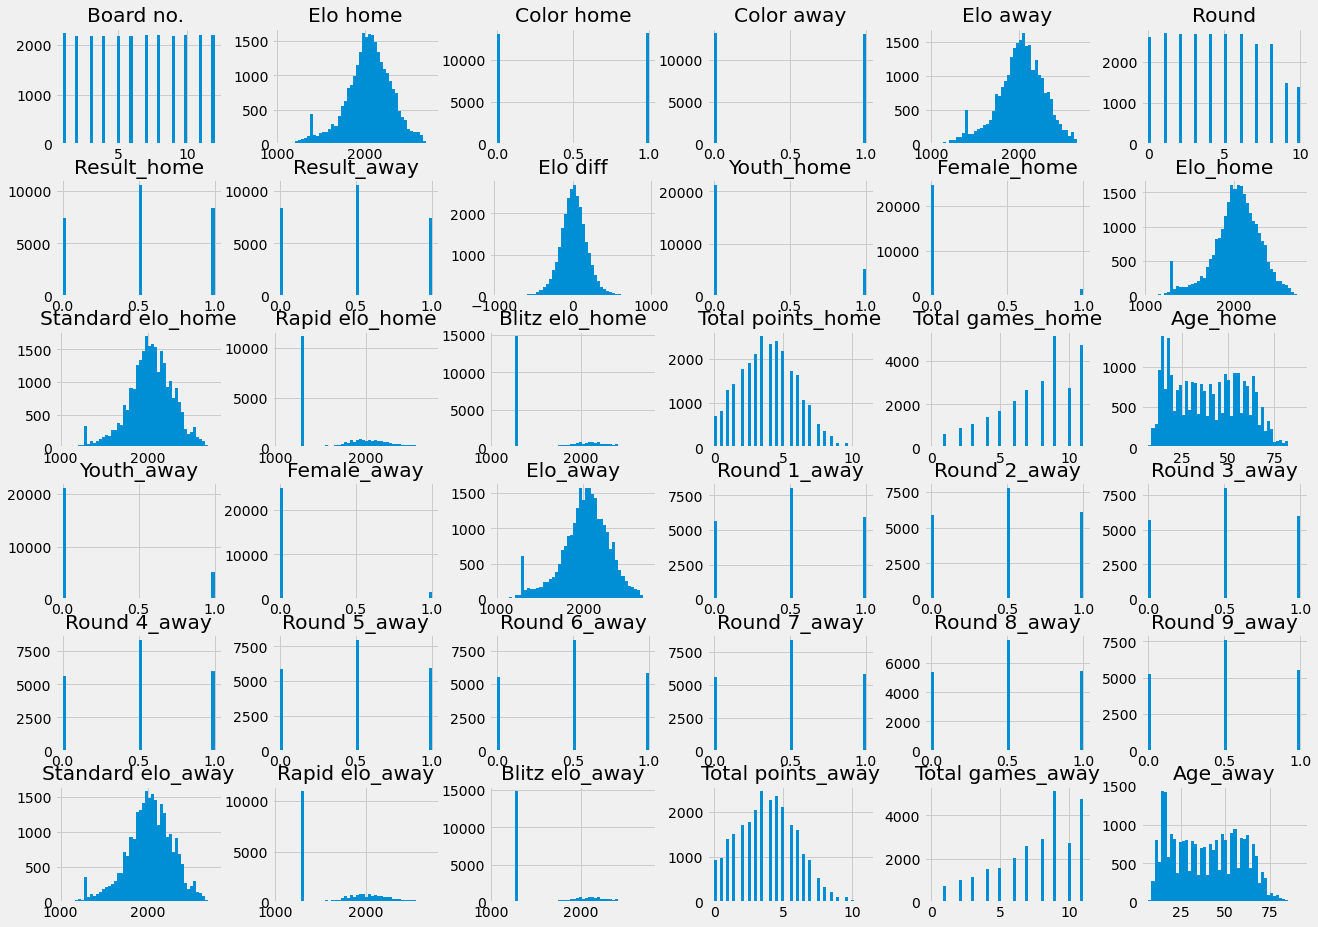

In [23]:
# plotting non fide stats

df_no_fide = df.loc[:,~df.columns.str.startswith(('2015', '2016', '2017', '2018', '2019', '2020'))]
df_no_fide.head(2)
df_no_fide.hist(bins=50, figsize=(20,15))

array([[<AxesSubplot:xlabel='Elo_home', ylabel='Elo_home'>,
        <AxesSubplot:xlabel='Elo_away', ylabel='Elo_home'>,
        <AxesSubplot:xlabel='Age_home', ylabel='Elo_home'>,
        <AxesSubplot:xlabel='Age_away', ylabel='Elo_home'>,
        <AxesSubplot:xlabel='Elo diff', ylabel='Elo_home'>],
       [<AxesSubplot:xlabel='Elo_home', ylabel='Elo_away'>,
        <AxesSubplot:xlabel='Elo_away', ylabel='Elo_away'>,
        <AxesSubplot:xlabel='Age_home', ylabel='Elo_away'>,
        <AxesSubplot:xlabel='Age_away', ylabel='Elo_away'>,
        <AxesSubplot:xlabel='Elo diff', ylabel='Elo_away'>],
       [<AxesSubplot:xlabel='Elo_home', ylabel='Age_home'>,
        <AxesSubplot:xlabel='Elo_away', ylabel='Age_home'>,
        <AxesSubplot:xlabel='Age_home', ylabel='Age_home'>,
        <AxesSubplot:xlabel='Age_away', ylabel='Age_home'>,
        <AxesSubplot:xlabel='Elo diff', ylabel='Age_home'>],
       [<AxesSubplot:xlabel='Elo_home', ylabel='Age_away'>,
        <AxesSubplot:xlabel='Elo_away

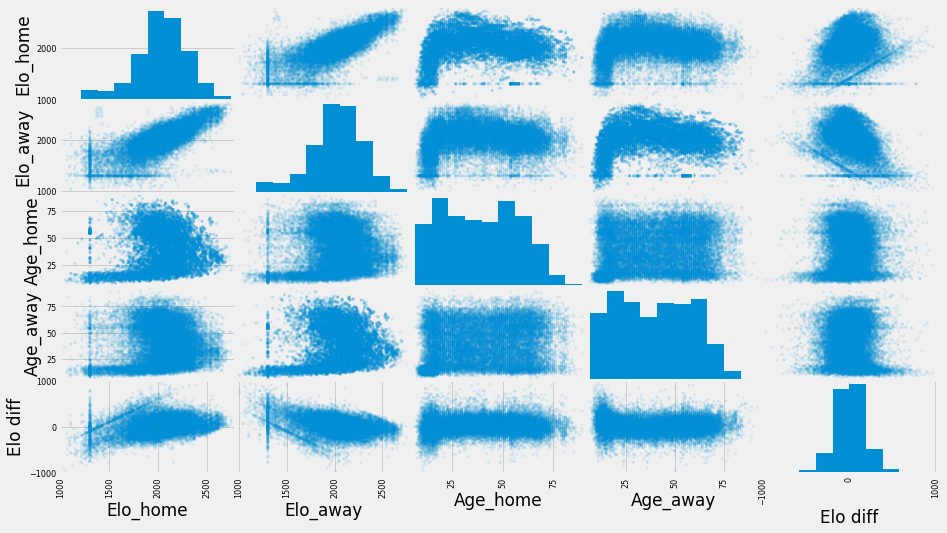

In [24]:
from pandas.plotting import scatter_matrix

# correlations between some features

attributes = ['Elo_home', 'Elo_away', 'Age_home', 'Age_away', 'Elo diff']
scatter_matrix(df[attributes], figsize=(14,8), alpha=0.1)

In [25]:
from functools import reduce

def youth_female_performance(df):
    
    youth_home = pd.pivot_table(df[df.Youth_home==1], index=['Season', 'League_type'],values=['Result_home'], aggfunc=np.mean)
    youth_home = youth_home.add_prefix('Youth_')

    youth_away = pd.pivot_table(df[df.Youth_away==1], index=['Season', 'League_type'],values=['Result_away'], aggfunc=np.mean)
    youth_away = youth_away.add_prefix('Youth_')
    
    female_home = pd.pivot_table(df[df.Female_home==1], index=['Season', 'League_type'],values=['Result_home'], aggfunc=np.mean)
    female_home = female_home.add_prefix('Female_')
    
    female_away = pd.pivot_table(df[df.Female_away==1], index=['Season', 'League_type'],values=['Result_away'], aggfunc=np.mean)
    female_away = female_away.add_prefix('Female_')
    
    standard_home = pd.pivot_table(df[(df.Female_home==0) & (df.Youth_home==0)], index=['Season', 'League_type'],values=['Result_home'], aggfunc=np.mean)
    standard_home = standard_home.add_prefix('Standard_')
    
    standard_away = pd.pivot_table(df[(df.Female_away==0) & (df.Youth_away==0)], index=['Season', 'League_type'],values=['Result_away'], aggfunc=np.mean)
    standard_away = standard_away.add_prefix('Standard_')
    
    pdList = [youth_home, youth_away, female_home, female_away, standard_home, standard_away]  # List of your dataframes
    all_data = reduce(lambda x,y: pd.merge(x,y, on=['Season','League_type'], how='outer'), pdList)
    
    all_data['Youth_overall'] = all_data.apply(lambda x: (x['Youth_Result_home'] + x['Youth_Result_away'])/2, axis=1)
    all_data['Female_overall'] = all_data.apply(lambda x: (x['Female_Result_home'] + x['Female_Result_away'])/2, axis=1)
    all_data['Standard_overall'] = all_data.apply(lambda x: (x['Standard_Result_home'] + x['Standard_Result_away'])/2, axis=1)
    
    return all_data 
    
pivot_home_away_category = youth_female_performance(df)
pivot_home_away_category.style.highlight_max(color = 'yellow', axis=1).highlight_min(color='lightblue', axis=1)

In [26]:
perf_stat_by_season = pivot_home_away_category.groupby(['League_type'], dropna=False).mean()
perf_stat_by_season.style.highlight_max(color = 'yellow', axis=1).highlight_min(color='lightblue', axis=1)

,Youth_Result_home,Youth_Result_away,Female_Result_home,Female_Result_away,Standard_Result_home,Standard_Result_away,Youth_overall,Female_overall,Standard_overall
League_type,,,,,,,,,
nb1,0.508425,0.481091,0.483662,0.443503,0.509361,0.498252,0.494758,0.463582,0.503807
nb1b,0.522903,0.463719,0.496728,0.451760,0.511855,0.493886,0.493311,0.474244,0.502870
nb2,0.539045,0.482649,0.498816,0.457216,0.515751,0.479757,0.510847,0.478016,0.497754


In [27]:
pivot_home_away_category.iloc[:,-3:].groupby('League_type').mean().style.highlight_max(color = 'yellow', axis=1).highlight_min(color='lightblue', axis=1)

,Youth_overall,Female_overall,Standard_overall
League_type,,,
nb1,0.494758,0.463582,0.503807
nb1b,0.493311,0.474244,0.502870
nb2,0.510847,0.478016,0.497754


<AxesSubplot:xlabel='League_type'>

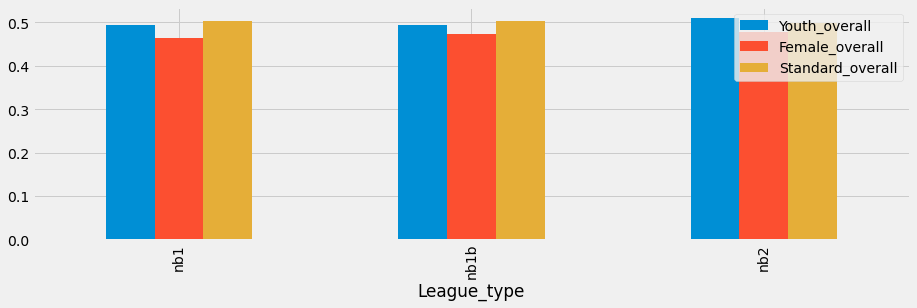

In [28]:
pivot_home_away_category.iloc[:,-3:].groupby('League_type').mean().plot.bar(figsize=(14,4))#)barh(ylim=0.4, figsize=(14,4), legend='central mid')

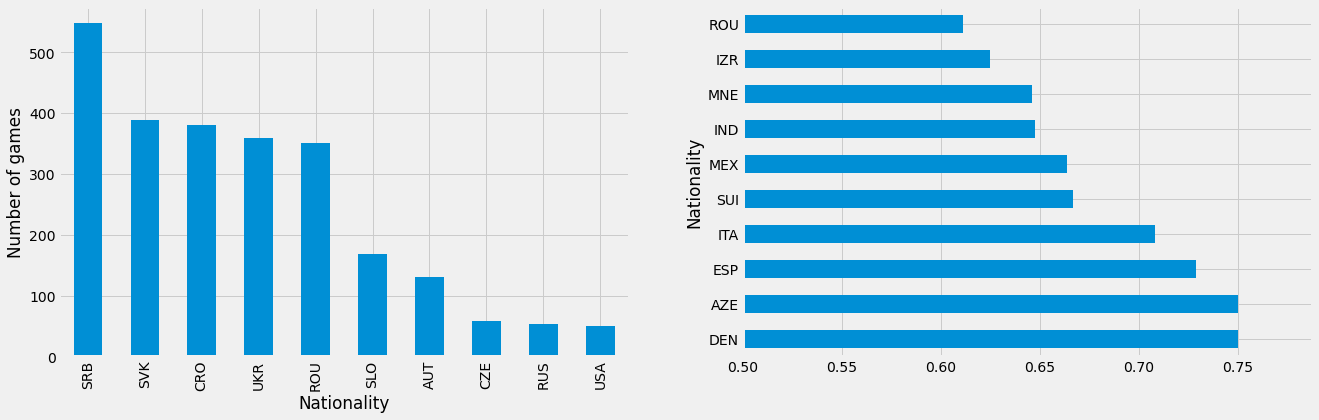

In [29]:
# Performance and number of games by nationality 
# might be scewed due to low number of games 

def nationality_games_and_performance(df):
    
    fig, axs = plt.subplots(1,2)
    
    nat_games=df.groupby('Nationality_home').size().sort_values(ascending=False)+df.groupby('Nationality_away').size().sort_values(ascending=False)
    nat_games.sort_values(ascending=False).dropna().iloc[1:].head(10).plot.bar(figsize=(20,6), ax=axs[0], xlabel='Nationality', ylabel='Number of games') # we drop the first row (as its obviously hungary)

    a = (df.groupby('Nationality_away')['Result_away'].mean() + df.groupby('Nationality_home')['Result_home'].mean())/2
    a.sort_values(ascending=False).dropna().head(10).plot.barh(figsize=(20,6), ax=axs[1], xlim=0.5, xlabel='Nationality', ylabel='Avg points per game')
    
    
nationality_games_and_performance(df)

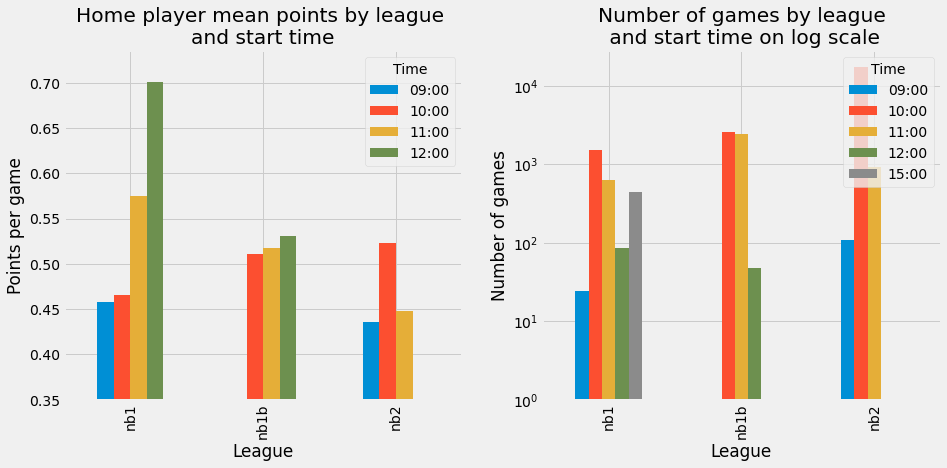

In [30]:


def start_time_analysis(df):
    fig, axs = plt.subplots(1,2)
    
    pd.pivot_table(df[df.Time != '15:00'], index=['League_type', 'Time'],values=['Result_home'], aggfunc=np.mean)
    pd.pivot_table(df[df.Time != '15:00'], index=['League_type', 'Time'],values=['Result_home'], aggfunc=np.mean)['Result_home'].unstack().plot.bar(figsize=(14,6), ylim=0.35, ax=axs[0], xlabel='League', ylabel='Points per game', title='Home player mean points by league \nand start time')
    df.groupby(['League_type', 'Time']).size().unstack().plot.bar(figsize=(14,6), log=True, ax=axs[1], xlabel='League', ylabel='Number of games', title='Number of games by league\n and start time on log scale')
start_time_analysis(df)

<AxesSubplot:xlabel='League_type'>

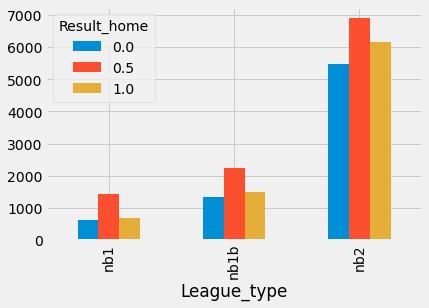

In [31]:
df.groupby(['League_type', 'Result_home']).size().unstack().plot.bar()

<AxesSubplot:xlabel='Time'>

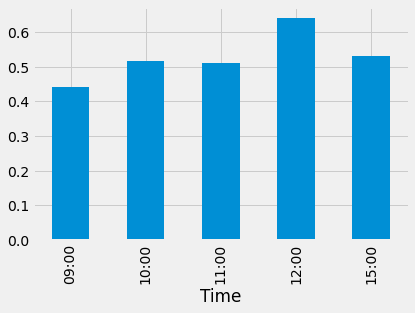

In [32]:
# youth player performance with respect to start time
df.groupby('Time')['Result_home'].mean().plot.bar()

<AxesSubplot:title={'center':'Female player performance on the \nroad at a given start time'}, xlabel='League_type'>

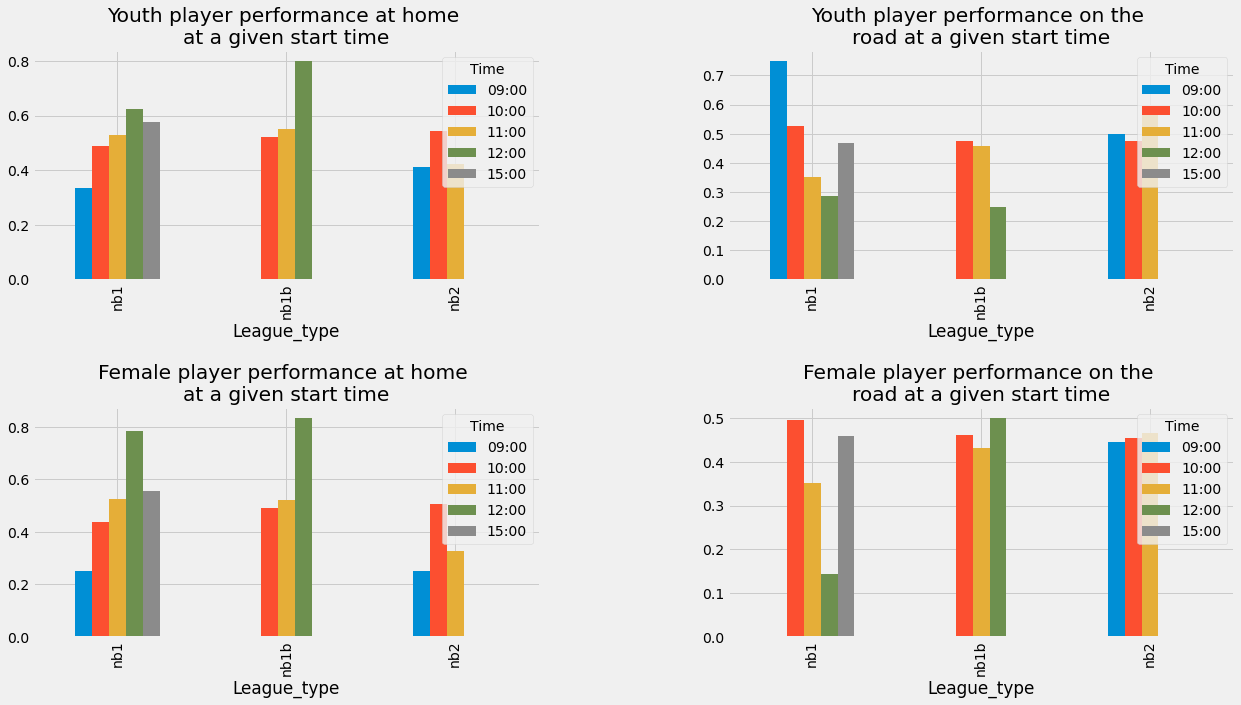

In [33]:
fig, axs = plt.subplots(2,2)
fig.tight_layout(h_pad=2) #makes the spacing better - no overlaps

df[df['Youth_home']==1].groupby(['League_type', 'Time'])['Result_home'].mean().unstack().plot.bar(ax=axs[0,0], figsize=(20,10), title='Youth player performance at home \nat a given start time')
df[df['Youth_away']==1].groupby(['League_type', 'Time'])['Result_away'].mean().unstack().plot.bar(ax=axs[0,1], figsize=(20,10), title='Youth player performance on the \nroad at a given start time')


df[df['Female_home']==1].groupby(['League_type', 'Time'])['Result_home'].mean().unstack().plot.bar(ax = axs[1,0], figsize=(20,10), title='Female player performance at home \nat a given start time')
df[df['Female_away']==1].groupby(['League_type', 'Time'])['Result_away'].mean().unstack().plot.bar(ax = axs[1,1], figsize=(20,10), title='Female player performance on the \nroad at a given start time')

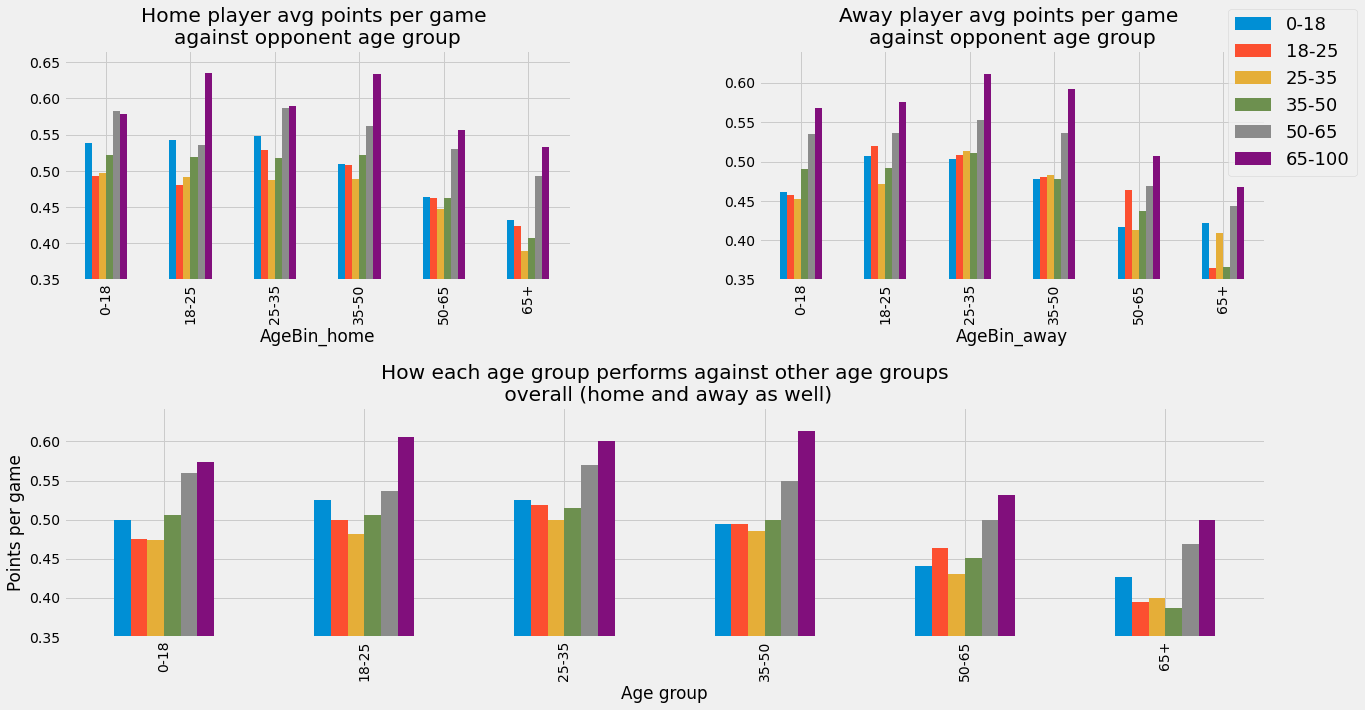

In [34]:
fig = plt.figure()

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

fig.tight_layout(h_pad=2)

mylabels = ['0-18', '18-25', '25-35', '35-50', '50-65', '65-100']


df.groupby(['AgeBin_home', 'AgeBin_away'])['Result_home'].mean().unstack().plot.bar(figsize=(20,10), ylim=0.35, ax=ax1, legend = None, title='Home player avg points per game \nagainst opponent age group')
df.groupby(['AgeBin_away', 'AgeBin_home'])['Result_away'].mean().unstack().plot.bar(figsize=(20,10), ylim=0.35, ax=ax2, legend = None, title='Away player avg points per game \nagainst opponent age group')
((df.groupby(['AgeBin_away', 'AgeBin_home'])['Result_away'].mean()+df.groupby(['AgeBin_home', 'AgeBin_away'])['Result_home'].mean()) / 2).unstack().plot.bar(figsize=(20,10), ax=ax3, legend=None, ylim=0.35, ylabel='Points per game', xlabel = 'Age group', title='How each age group performs against other age groups\n overall (home and away as well)')

fig.legend(mylabels, loc='upper right', prop={'size': 18})

<AxesSubplot:xlabel='AgeBin_away'>

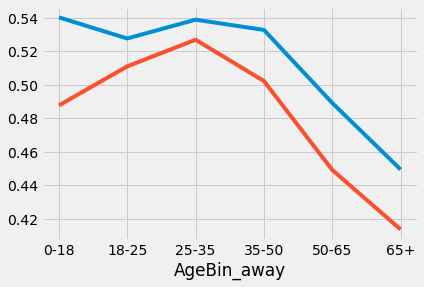

In [35]:
# AgeBin away / home 
# TODO: this plot is ugly

fig, axs = plt.subplots(1,1)

a = df.groupby(['AgeBin_home'])['Result_home'].mean()
b = df.groupby(['AgeBin_away'])['Result_away'].mean()

c = (df.groupby(['AgeBin_home'])['Result_home'].mean()+df.groupby(['AgeBin_away'])['Result_away'].mean())/2
a.plot(ax=axs)
b.plot(ax=axs)


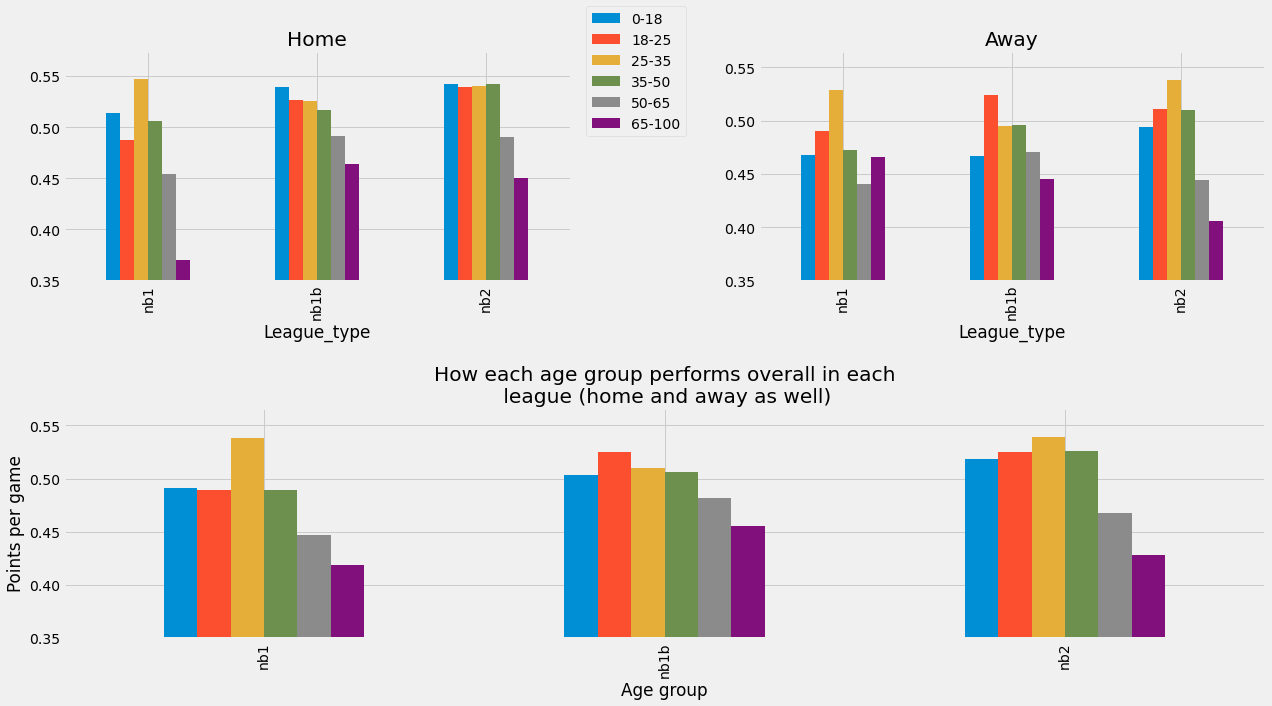

In [36]:
fig = plt.figure()

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

fig.tight_layout(h_pad=2)

mylabels = ['0-18', '18-25', '25-35', '35-50', '50-65', '65-100']

a = df.groupby(['League_type', 'AgeBin_home'])['Result_home'].mean().unstack().plot(ax=ax1, figsize=(14,4), kind='bar', legend=None, ylim=0.35, title='Home')
b = df.groupby(['League_type', 'AgeBin_away'])['Result_away'].mean().unstack().plot(ax=ax2, figsize=(14,4), kind='bar', legend=None, ylim=0.35, title='Away')
((df.groupby(['League_type', 'AgeBin_home'])['Result_home'].mean()+df.groupby(['League_type', 'AgeBin_away'])['Result_away'].mean()) / 2).unstack().plot.bar(figsize=(20,10), ax=ax3, legend=None, ylim=0.35, ylabel='Points per game', xlabel = 'Age group', title='How each age group performs overall in each\n league (home and away as well)')

fig.legend(mylabels, loc='upper center')


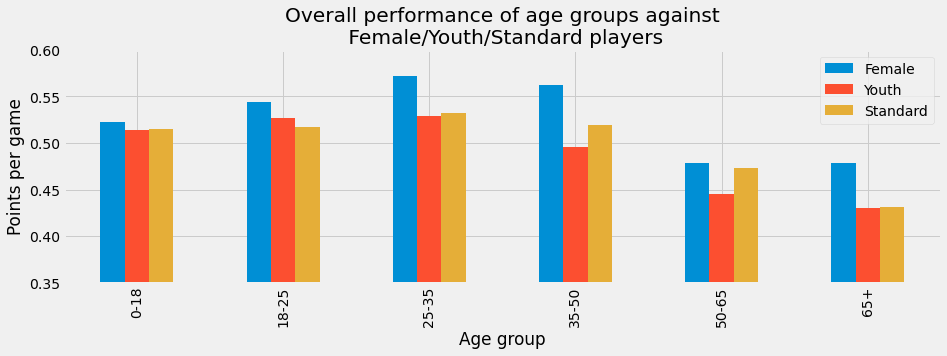

In [37]:
import matplotlib.patches as mpatches

a = df[df['Female_away'] == 1].groupby(['AgeBin_home'])['Result_home'].mean()
a.columns = ['AgeBin', 'Avg Points']
b = df[df['Female_home'] == 1].groupby(['AgeBin_away'])['Result_away'].mean()
b.columns = ['AgeBin', 'Avg Points']
res1 = (a+b)/2

c = df[df['Youth_away'] == 1].groupby(['AgeBin_home'])['Result_home'].mean()
c.columns = ['AgeBin', 'Avg Points']
d = df[df['Youth_home'] == 1].groupby(['AgeBin_away'])['Result_away'].mean()
d.columns = ['AgeBin', 'Avg Points']
res2 = (c+d)/2

e = df[(df['Youth_away'] == 0) & (df['Female_away'] == 0)].groupby(['AgeBin_home'])['Result_home'].mean()
e.columns = ['AgeBin', 'Avg Points']
f = df[(df['Youth_home'] == 0) & (df['Female_home'] == 0)].groupby(['AgeBin_away'])['Result_away'].mean()
f.columns = ['AgeBin', 'Avg Points']
res3 = (e+f)/2

res = pd.concat([res1, res2, res3],axis=1)

res.plot(figsize=(14,4), kind='bar', ylim=0.35, ylabel = 'Points per game', xlabel ='Age group', title='Overall performance of age groups against\n Female/Youth/Standard players')
plt.legend(labels=['Female', 'Youth', 'Standard'])

<AxesSubplot:xlabel='Time'>

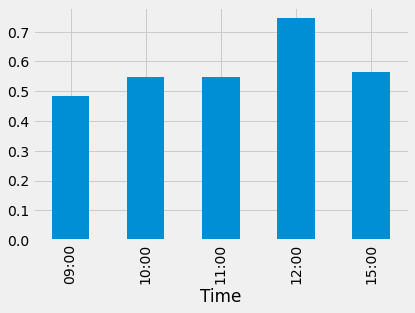

In [38]:
# performance of white players for each start time 
df[df['Color home']==0].groupby('Time')['Result_home'].mean().plot.bar()

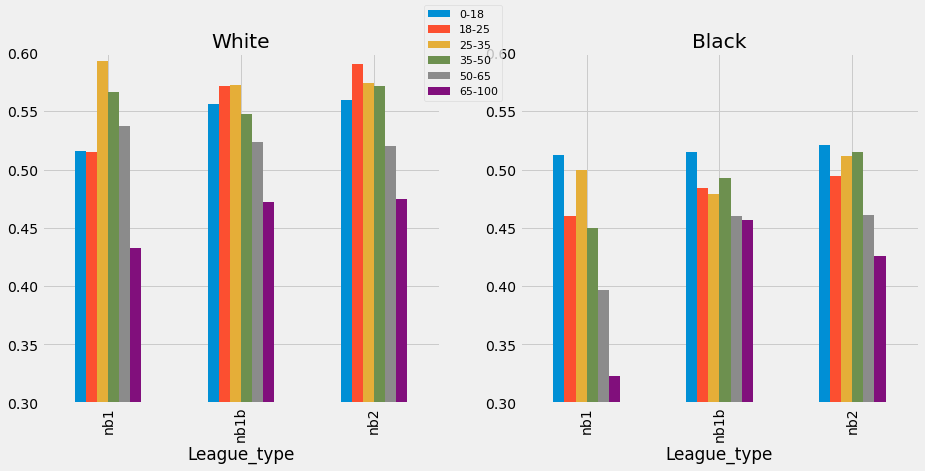

In [39]:
fig, axs = plt.subplots(1,2)

df[df['Color home']==0].groupby(['League_type', 'AgeBin_home'])['Result_home'].mean().unstack().plot.bar(ylim=(0.3,0.6), ax=axs[0], figsize=(14,6), legend=None, title="White")
df[df['Color home']==1].groupby(['League_type', 'AgeBin_home'])['Result_home'].mean().unstack().plot.bar(ylim=(0.3,0.6), ax=axs[1], figsize=(14,6), legend=None, title="Black")

fig.legend(mylabels, loc='upper center', fontsize=11)

In [40]:
df.groupby(['League_type', 'AgeBin_home'])['Elo home'].median() - df.groupby(['League_type', 'AgeBin_away'])['Elo away'].median()

League_type  AgeBin_home
nb1          0-18           14.0
             18-25          -0.5
             25-35          11.0
             35-50           4.0
             50-65          48.5
             65+             0.0
nb1b         0-18           15.0
             18-25           0.0
             25-35           3.0
             35-50           7.0
             50-65           7.0
             65+             0.0
nb2          0-18           10.0
             18-25           9.0
             25-35          -4.0
             35-50           7.0
             50-65          17.0
             65+            12.0
dtype: float64

<AxesSubplot:ylabel='League_type'>

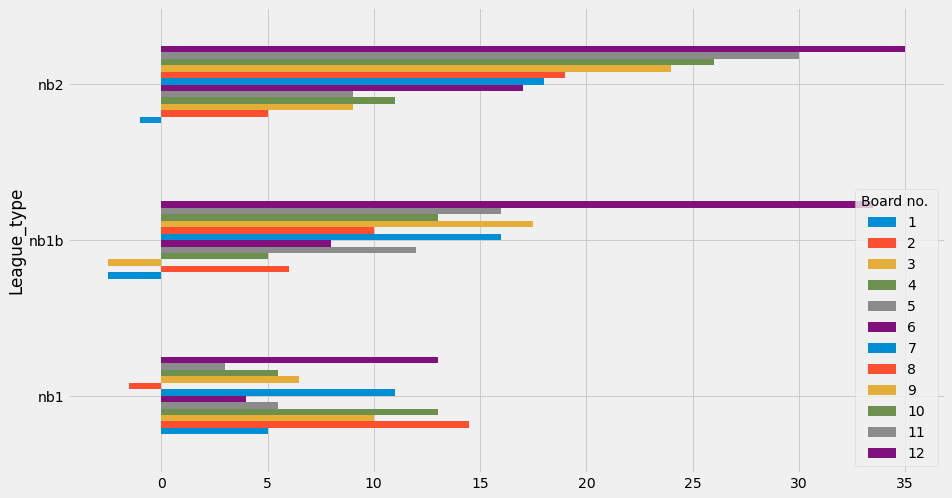

In [41]:
# difference between home and away player strengths per board 
(df.groupby(['League_type', 'Board no. '])['Elo home'].median() - df.groupby(['League_type', 'Board no. '])['Elo away'].median()).unstack().plot.barh(figsize=(14,8))

In [42]:
df[df['League_type']=='nb1'].groupby('AgeBin_home')['Board no. '].median()

AgeBin_home
0-18     10
18-25     7
25-35     5
35-50     6
50-65     7
65+       8
Name: Board no. , dtype: int64

In [43]:
# TODO: 

# feher/fekete mennyit szamit (femalenek, youthnak, agebinnek, titlenek)
# title vs female / youth 
# jatekosokat elo alapjan bin-be tenni ...
# partikat elodiff alapjan binbe tenni
# halis statisztikák :) 
# ligankent/csapatonkent legtobb ifi/no/sima
# -->> "Mozgo teljesitmeny" : megeri e jatszatni azokat, akiknek nem ment jol a korabbi fordulokban !
# expected points vs earned (how do i calculate expected points? pure avg vs model? )



In [44]:
def best_performers(ranklist, minimum_games=3, youth=False, female=False, season=None, league=None, team=None):
    if youth and female:
        ranklist = ranklist[(ranklist['Youth'] == 1) & (ranklist['Female'] == 1) ]
    elif youth:
        ranklist = ranklist[ranklist['Youth'] == 1 ]
    elif female:
        ranklist = ranklist[ranklist['Female'] == 1 ]
    
    if season is not None:
        ranklist = ranklist[ranklist['Season']==season]
    
    if league is not None:
        ranklist = ranklist[ranklist['League']==league]
    
    if team is not None:
        ranklist = ranklist[ranklist['Team name'].str.contains(team)]
    
    # [(ranklist['Season'] == season)]
    best_performers = ranklist.groupby(['Player name', 'Season'], as_index=False).apply(lambda x: x['Opponent Avg'].mean() + 8*((x['Total points'].sum() / x['Total games'].sum())*100 - 50) if x['Total games'].sum() >= minimum_games else 0)
    best_performers.columns = ['Player', 'Season', 'Performance over all leagues']
    
    return best_performers
    
# a = best_performers(b_rank, '19-20', youth=False, female=False)

# data = a.sort_values(by='Performance over all leagues', ascending=False).head(15)
# plt.figure(figsize=(12,8))
# plt.barh(data['Player'],data['Performance over all leagues'])
# plt.xlim(data['Performance over all leagues'].min()-100)
# ax = plt.gca()
# ax.invert_yaxis()
# plt.show()


In [45]:
# this needs correction !!

all_ranklist['Team name'].unique()

array(['Aquaprofit-NTSK I.', 'ASE Paks', 'HVSE-Infraplan',
       'Budapesti Titánok', 'Z.Csuti-Hydrocomp SK', 'Pénzügyőr SE',
       'ASS-Makói SVSE', 'Aquaréna Kőbánya SC', 'Dunaharaszti MTK',
       'HÜSI SC', 'Aquaprofit-NTSK II.', 'Lila Futó-Hóbagoly',
       'MTK Budapest', 'Decs 1990', 'ASE II. Paks',
       'Tapolca Rockwool VSE', 'SZ-A STE', 'Komlói BSK',
       'Balatonfüredi SC', 'DVTK - EMSE', 'Tóth László SE',
       'Kisújszállási SE', 'Vasas SC', 'Magyar Sakkvilág-TSE',
       'Maróczy SE', 'MLTC', 'Szigetszentmiklós', 'Sakk Egylet Nagyatád',
       nan, 'Decs 1990 II.', 'Fehérvár SE', 'Karmin PSSE', 'Szentlőrinc',
       'Királysakk SE', 'Marcali VSZSE', 'Kaposvári Bástya SE',
       'Péti MTE', 'Sárosd SE', 'D. Sakkiskola-Kwizda',
       'MVSI-Misk. KisBocsok', 'Hajdúböszörményi SE', 'Debr. Sakkbarátok',
       'Edelényi VSE.', 'Nyíregyházi SISE', 'Hajdúszoboszlói SSE',
       'Tiszavasvári SE', 'Kbarcika VSC', 'Mezőkövesd SE.', 'SSASSE',
       'Nádudvari Sakk SE.', '

In [51]:
def add_ranklist_opponent_rating(games, ranklist):
    
    opponent_rating_cols = [col+" opp elo" for col in ranklist if "Round" in col]
    
    # don't do this  
    for index, row in games.iterrows():
        
        ranklist.loc[(ranklist['Player name'] == row['Player home']) & (ranklist['Season'] == row['Season']) & 
                    (ranklist['League'] == row['League']), [f"Round {row['Round']} opp elo", f"Round {row['Round']} color"]] = [row['Elo away'], row['Color home']]
        
        ranklist.loc[(ranklist['Player name'] == row['Player away']) & (ranklist['Season'] == row['Season']) & 
                    (ranklist['League'] == row['League']), [f"Round {row['Round']} opp elo", f"Round {row['Round']} color"]] = [row['Elo home'], row['Color away']]
    
    # select the columns where the opponent ratings are stored
    opponent_rating_cols = [col for col in ranklist if " opp elo" in col]
    
    # calculate the average of the played opponents
    ranklist.loc[:,'Opponent Avg'] = ranklist.loc[:,opponent_rating_cols].mean(axis=1)
    
    # calculate the linear performance (not fide) of the player
    ranklist.loc[:,'League Performance'] = ranklist.loc[:,'Opponent Avg'] + 8*((ranklist.loc[:,'Total points'] / ranklist.loc[:,'Total games'])*100 - 50).fillna(0)
   
    perf_table = best_performers(ranklist).reset_index(level=0,drop=True).reset_index(level=0,drop=True)
    perf_table.fillna(0)
    ranklist = pd.merge(ranklist, perf_table, left_on=['Player name', 'Season'], right_on=['Player', 'Season'])
    
    del ranklist['Player']

    # color_cols = [col for col in ranklist if "color" in df.columns]
    # todo white game count 
    # todo black game count
    
    return ranklist

ranklist = add_ranklist_opponent_rating(df, all_ranklist)
ranklist

,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,Round 7 color,Round 8 opp elo,Round 8 color,Round 9 opp elo,Round 9 color,Round 10 opp elo,Round 10 color,Opponent Avg,League Performance,Performance over all leagues
0,Anand Viswanathan,0,0,IND,GM,2816.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,Naiditsch Arkadij,0,0,GER,GM,2684.0,NaN,NaN,NaN,NaN,...,1.0,2507.0,0.0,NaN,NaN,NaN,NaN,2577.500000,2577.500000,0.000000
2,Shirov Alexei,0,0,ESP,GM,2712.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,Efimenko Zahar,0,0,UKR,GM,2647.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2508.000000,2908.000000,0.000000
4,Balogh Csaba,0,0,HUN,GM,2659.0,NaN,NaN,0.5,NaN,...,0.0,2510.0,1.0,NaN,NaN,NaN,NaN,2532.666667,2599.333333,2599.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20441,Oskó Lajos,0,0,HUN,NaN,1543.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
20442,Gottfried Zsolt,0,0,HUN,NaN,1279.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
20443,Kocmar Kitti,1,1,HUN,NaN,1325.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
20444,Csesznok Balázs István,1,0,HUN,NaN,1300.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [76]:
# best performers of Haladas VSE in 19-20 season

grouped = best_performers(ranklist, season='19-20', minimum_games=3, youth=False, team='HVSE')

grouped = pd.merge(grouped.reset_index(level=0, drop=True).reset_index(level=0, drop=True), ranklist[['Player name', 'Season', 'Elo']], left_on=['Player', 'Season'], right_on=['Player name', 'Season'])
del grouped['Player name']
grouped.loc[:,'Relative performance'] = grouped['Performance over all leagues'] - grouped['Elo']
grouped = grouped.drop_duplicates()
grouped.sort_values(by='Relative performance', ascending=False).rename(columns={'Performance over all leagues':'Performance'}).head(20)

# TODO: I forgot to check teams as well, hence Kiss Attila (a ~2300 player) was confused with another Kiss Attila(~1700 player)
# (i think it's only one more condition so no big deal)

,Player,Season,Performance,Elo,Relative performance
55,Kiss Attila,19-20,2250.555556,1810.0,440.555556
0,András Ferenc,19-20,1627.666667,1342.0,285.666667
24,Farkas Boglárka,19-20,1646.166667,1391.0,255.166667
29,Gaál Ede,19-20,2277.000000,2038.0,239.000000
35,Gömböcz Zsófia,19-20,2146.600000,1911.0,235.600000
137,Tóth Tibor,19-20,1872.000000,1640.0,232.000000
42,Horváth Réka,19-20,2242.866667,2015.0,227.866667
145,Vilics Hanna,19-20,1462.000000,1253.0,209.000000
104,Ruck Róbert,19-20,2721.000000,2530.0,191.000000
18,Csonka Attila István,19-20,2525.178571,2359.0,166.178571


In [78]:
ranklist[ranklist['Player name']=='Kiss Attila']

,Player name,Youth,Female,Nationality,Title,Elo,Round 1,Round 2,Round 3,Round 4,...,Round 7 color,Round 8 opp elo,Round 8 color,Round 9 opp elo,Round 9 color,Round 10 opp elo,Round 10 color,Opponent Avg,League Performance,Performance over all leagues
217,Kiss Attila,0,0,HUN,IM,2374.0,NaN,0.5,0.5,0.5,...,0.0,2454.0,1.0,NaN,NaN,NaN,NaN,2420.500000,2370.500000,2370.500000
218,Kiss Attila,0,0,HUN,NaN,1300.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2370.500000
219,Kiss Attila,0,0,HUN,NaN,1300.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2370.500000
4781,Kiss Attila,0,0,HUN,IM,2371.0,0.5,0.0,0.5,0.5,...,0.0,2373.0,0.0,NaN,NaN,NaN,NaN,2415.222222,2326.333333,2326.333333
4782,Kiss Attila,0,0,HUN,NaN,1300.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2326.333333
8672,Kiss Attila,0,0,HUN,IM,2357.0,NaN,0.5,0.0,0.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2400.000000,2266.666667,2266.666667
8673,Kiss Attila,0,0,HUN,NaN,1787.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2266.666667
12815,Kiss Attila,0,0,HUN,IM,2334.0,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2393.250000,2293.250000,2345.930556
12816,Kiss Attila,0,0,HUN,IM,2334.0,NaN,0.5,0.5,NaN,...,NaN,2345.0,1.0,NaN,NaN,2459.0,0.0,2387.500000,2387.500000,2345.930556
12817,Kiss Attila,0,0,HUN,NaN,1810.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2345.930556


In [ ]:
# ranklist team name has numerical values.. 
# 17-18 nb1b season is still faulty


In [58]:
#categoricals = ['Title home', 'Title away', 'League_type', 'AgeBin_home', 'AgeBin_away']

#abs(df.corrwith(df['Result_home'])).sort_values(ascending=False).head(20).plot.barh()

## Prediction with models

In [60]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

for col in ['Title home', 'Title away', 'League_type', 'AgeBin_home', 'AgeBin_away', 'Result_home']:
    df.loc[:,col] = df.loc[:,col].astype('category')
    df.loc[:,f"{col}_code"] = df.loc[:,col].astype('category').cat.codes

target = 'Result_home_code'
feats = ['Female_home', 'Female_away', 'Youth_home', 'Youth_away', 'Elo home', 'Elo away',
        'Standard elo_home', 'Rapid elo_home','Blitz elo_home', 'Age_home', 'Standard elo_away', 'Rapid elo_away',
         'Blitz elo_away','Age_away', 'Elo diff','Color home', 'Color away']

model_data = df.loc[:, feats+[target,'Title home_code', 'Title away_code', 'League_type_code', 'AgeBin_home_code', 'AgeBin_away_code']].dropna()

model_data = model_data[(model_data['Elo home']>2000) & (model_data['Elo away']>2000)]
   
    
# Standard Scaler : 

#numeric_cols = model_data.select_dtypes(include=np.number).columns.tolist()
#numeric_cols.remove('Result_home_code')
#standard_scaler = StandardScaler()
#model_data[numeric_cols] = standard_scaler.fit_transform(model_data[numeric_cols])

kf = KFold(10)

df_pred = pd.DataFrame()

for train_idx, test_idx in kf.split(model_data, groups=model_data['League_type_code']):
    train = model_data.iloc[train_idx]
    test = model_data.iloc[test_idx]
    model = RandomForestClassifier()
    model.fit(train.loc[:,feats], train.loc[:,target])
    test.loc[:,f'{target}_pred'] = pd.Series(model.predict(test.loc[:,feats]), index=test.index )
    df_pred = df_pred.append(test)

df_pred.shape

D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
D:\Anaconda\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the do

(12306, 24)

In [61]:
df_pred.head(3)

,Female_home,Female_away,Youth_home,Youth_away,Elo home,Elo away,Standard elo_home,Rapid elo_home,Blitz elo_home,Age_home,...,Elo diff,Color home,Color away,Result_home_code,Title home_code,Title away_code,League_type_code,AgeBin_home_code,AgeBin_away_code,Result_home_code_pred
0,0,0.0,0,0.0,2374,2557,2344.0,2376.0,2342.0,45,...,-183.0,1,0,0,4,3,0,3,2,0
1,0,0.0,1,0.0,2362,2565,2384.0,2247.0,2302.0,14,...,-203.0,0,1,1,5,3,0,0,3,1
2,0,0.0,0,0.0,2470,2469,2443.0,2485.0,2482.0,45,...,1.0,1,0,1,3,4,0,3,2,1


In [62]:
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(df_pred[target], df_pred[f"{target}_pred"])

array([[1141, 1783,  275],
       [ 823, 4205,  823],
       [ 268, 1809, 1179]], dtype=int64)

In [63]:
print(classification_report(df_pred[target], df_pred[f"{target}_pred"]))

              precision    recall  f1-score   support

           0       0.51      0.36      0.42      3199
           1       0.54      0.72      0.62      5851
           2       0.52      0.36      0.43      3256

    accuracy                           0.53     12306
   macro avg       0.52      0.48      0.49     12306
weighted avg       0.53      0.53      0.51     12306



<AxesSubplot:>

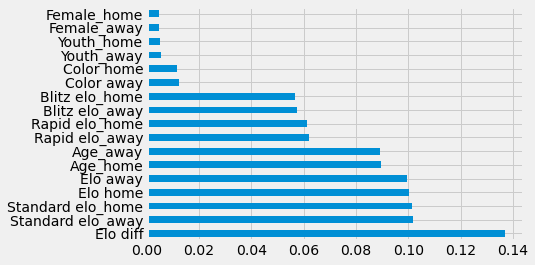

In [64]:
feat_importances = pd.Series(model.feature_importances_, index=train.loc[:,feats].columns)
feat_importances.nlargest(25).plot(kind='barh')

In [65]:
df_pred[(df_pred[target]!=df_pred[f"{target}_pred"]) & (df_pred[f"{target}_pred"]!=1) & (df_pred[target]!=1)]

,Female_home,Female_away,Youth_home,Youth_away,Elo home,Elo away,Standard elo_home,Rapid elo_home,Blitz elo_home,Age_home,...,Elo diff,Color home,Color away,Result_home_code,Title home_code,Title away_code,League_type_code,AgeBin_home_code,AgeBin_away_code,Result_home_code_pred
16,0,0.0,0,0.0,2338,2420,2346.0,1300.0,2277.0,30,...,-82.0,1,0,2,4,3,0,2,3,0
70,0,0.0,0,1.0,2307,2242,2369.0,2247.0,2300.0,32,...,65.0,1,0,0,2,5,0,2,0,2
119,1,0.0,0,1.0,2057,2260,2003.0,1966.0,1973.0,28,...,-203.0,0,1,2,9,5,0,2,0,0
160,0,0.0,0,0.0,2608,2421,2599.0,2575.0,2587.0,28,...,187.0,0,1,0,3,4,0,2,1,2
215,0,0.0,1,1.0,2308,2362,2336.0,2294.0,1300.0,16,...,-54.0,1,0,2,5,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26731,0,0.0,0,1.0,2117,2036,2053.0,2016.0,1300.0,35,...,81.0,0,1,0,5,5,2,2,0,2
26754,0,0.0,0,1.0,2090,2024,2047.0,1300.0,1300.0,65,...,66.0,1,0,0,5,5,2,4,0,2
26788,0,0.0,0,0.0,2146,2010,2138.0,1946.0,2055.0,20,...,136.0,0,1,0,5,5,2,1,1,2
26863,1,0.0,0,0.0,2042,2141,2028.0,1300.0,1300.0,64,...,-99.0,0,1,2,5,5,2,4,3,0


In [66]:
df.isna().sum().sort_values(ascending=False)

EloBin home                                    25510
EloBin away                                    25347
Title_away                                     19543
Round 9_away                                    7938
Round 8_away                                    7883
                                               ...  
2015 Year blitz games total_away                   0
2015 Year standard rating change total_away        0
2015 Year rapid rating change total_away           0
2015 Year blitz rating change total_away           0
Home team                                          0
Length: 151, dtype: int64

In [ ]:
target = 'Result_home_code'
# feats = ['Female_home', 'Female_away', 'Youth_home', 'Youth_away', 'Elo home', 'Elo away',
#         'Standard elo_home', 'Rapid elo_home','Blitz elo_home', 'Age_home', 'Standard elo_away', 'Rapid elo_away',
#          'Blitz elo_away','Age_away', 'Elo diff','Color home', 'Color away']

feat = df.columns.values
feat2 = np.delete(feat, np.where(feat == 'Result_home'))
feats = np.delete(feat2, np.where(feat2 == 'Result_home'))

model_data = df.loc[:, df.columns.values]
model_data = model_data[(model_data['Elo home']>2000) & (model_data['Elo away']>2000)]

kf = KFold(10)

df_pred = pd.DataFrame()

for train_idx, test_idx in kf.split(model_data, groups=model_data['League_type_code']):
    train = model_data.iloc[train_idx]
    test = model_data.iloc[test_idx]
    model = RandomForestClassifier()
    model.fit(train.loc[:,feats], train.loc[:,target])
    test.loc[:,f'{target}_pred'] = pd.Series(model.predict(test.loc[:,feats]), index=test.index )
    df_pred = df_pred.append(test)

df_pred.shape

In [ ]:
df_pred.head(2)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(df_pred[target], df_pred[f"{target}_pred"]))
print(classification_report(df_pred[target], df_pred[f"{target}_pred"]))

In [ ]:
feat_importances = pd.Series(model.feature_importances_, index=train.loc[:,df.columns.values].columns)
feat_importances.nsmallest(10).plot(kind='barh')

In [ ]:
#corr_plot = df.corr().loc[:,'Result_home'].sort_values(ascending=False).reset_index()
#corr_plot.head(15)